# Big Data Coursework - US Treasury Bond Return Prediction

## 1. Read Data

In [1]:
import pandas as pd
import numpy as np
import pandas_datareader.data as pdr
import datetime
import yfinance as yf
import plotly.express as px

from statsmodels.tsa.stattools import adfuller
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm

from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.neural_network import MLPRegressor

from sklearn.experimental import enable_halving_search_cv  # noqa: F401
from sklearn.model_selection import HalvingRandomSearchCV

from scipy.stats import loguniform

### 1.1 FRED Data

In [2]:
start = datetime.datetime(1990, 1, 1)
end = datetime.datetime(2026, 1, 31)

fred_codes = [
    'DGS10',    # 10-year Treasury yield
    'T10Y2Y',   # Term spread
    'DGS5',     # 5-Year Treasury yield
    'DGS2',     # 2-Year Treasury yield
    'TB3MS',    # 3-Month Treasury rate
    'BAA',      # Moody's BAA Corporate Bond Yield
    'AAA',      # Moody's AAA Corporate Bond Yield
    'BAMLC0A0CMEY', # ICE BofA US Corporate Index Effective Yield
    'BAMLH0A0HYM2EY', # ICE BofA US High Yield Index Effective Yield
    'TEDRATE',  # TED Spread (3M LIBOR - 3M T-Bill)
    'CPIAUCSL', # Consumer Price Index
    'T10YIE',   # 10-Year Breakeven Inflation Rate
    'UNRATE',   # Unemployment Rate
    'INDPRO',   # Industrial Production Index
    'USREC',    # NBER Recession Indicator
    'VIXCLS',   # VIX Index (Equity Vo2latility)
]

df_fred = pdr.DataReader(fred_codes, 'fred', start, end)

In [3]:
df_fred.head()

DGS10  T10Y2Y  DGS5  DGS2  TB3MS   BAA   AAA  BAMLC0A0CMEY  \
DATE                                                                     
1990-01-01    NaN     NaN   NaN   NaN   7.64  9.94  8.99           NaN   
1990-01-02   7.94    0.07  7.87  7.87    NaN   NaN   NaN           NaN   
1990-01-03   7.99    0.05  7.92  7.94    NaN   NaN   NaN           NaN   
1990-01-04   7.98    0.06  7.91  7.92    NaN   NaN   NaN           NaN   
1990-01-05   7.99    0.09  7.92  7.90    NaN   NaN   NaN           NaN   

            BAMLH0A0HYM2EY  TEDRATE  CPIAUCSL  T10YIE  UNRATE  INDPRO  USREC  \
DATE                                                                           
1990-01-01             NaN      NaN     127.5     NaN     5.4  61.729    0.0   
1990-01-02             NaN     0.80       NaN     NaN     NaN     NaN    NaN   
1990-01-03             NaN     0.75       NaN     NaN     NaN     NaN    NaN   
1990-01-04             NaN     0.79       NaN     NaN     NaN     NaN    NaN   
1990-01-05             NaN     0.84       NaN     NaN     NaN     NaN    NaN   

            VIXCLS  
DATE                
1990-01-01     NaN  
1990-01-02   17.24  
1990-01-03   18.19  
1990-01-04   19.22  
1990-01-05   20.11

In [3]:
# resample to monthly frequency (using end-of-month values)
df_fred_monthly = df_fred.resample('MS').last()

df_fred_monthly.head()

DGS10  T10Y2Y  DGS5  DGS2  TB3MS    BAA   AAA  BAMLC0A0CMEY  \
DATE                                                                      
1990-01-01   8.43    0.15  8.35  8.28   7.64   9.94  8.99           NaN   
1990-02-01   8.51    0.08  8.44  8.43   7.74  10.14  9.22           NaN   
1990-03-01   8.65    0.01  8.65  8.64   7.90  10.21  9.37           NaN   
1990-04-01   9.04    0.08  9.04  8.96   7.77  10.30  9.46           NaN   
1990-05-01   8.60    0.10  8.56  8.50   7.74  10.41  9.47           NaN   

            BAMLH0A0HYM2EY  TEDRATE  CPIAUCSL  T10YIE  UNRATE   INDPRO  USREC  \
DATE                                                                            
1990-01-01             NaN     0.63     127.5     NaN     5.4  61.7290    0.0   
1990-02-01             NaN     0.61     128.0     NaN     5.3  62.2896    0.0   
1990-03-01             NaN     0.70     128.6     NaN     5.2  62.5999    0.0   
1990-04-01             NaN     0.90     128.9     NaN     5.4  62.4359    0.0   
1990-05-01             NaN     0.62     129.1     NaN     5.4  62.6258    0.0   

            VIXCLS  
DATE                
1990-01-01   25.36  
1990-02-01   21.99  
1990-03-01   19.73  
1990-04-01   19.52  
1990-05-01   17.37

In [5]:
df_fred_monthly.tail()

DGS10  T10Y2Y  DGS5  DGS2  TB3MS   BAA   AAA  BAMLC0A0CMEY  \
DATE                                                                     
2025-09-01   4.16    0.56  3.74  3.60   3.92  5.83  5.21          4.83   
2025-10-01   4.11    0.51  3.71  3.60   3.82  5.74  5.13          4.82   
2025-11-01   4.02    0.55  3.59  3.47   3.78  5.86  5.26          4.78   
2025-12-01   4.18    0.71  3.73  3.47   3.59  5.90  5.31          4.84   
2026-01-01   4.26    0.74  3.79  3.52   3.57  5.88  5.34          4.85   

            BAMLH0A0HYM2EY  TEDRATE  CPIAUCSL  T10YIE  UNRATE    INDPRO  \
DATE                                                                      
2025-09-01            6.56      NaN   324.245    2.36     4.4  101.7059   
2025-10-01            6.67      NaN       NaN    2.30     NaN  101.2570   
2025-11-01            6.56      NaN   325.063    2.23     4.5  101.3775   
2025-12-01            6.53      NaN   326.031    2.25     4.4  101.6296   
2026-01-01            6.66      NaN   326.588    2.36     4.3  102.3412   

            USREC  VIXCLS  
DATE                       
2025-09-01    0.0   16.28  
2025-10-01    0.0   17.44  
2025-11-01    0.0   16.35  
2025-12-01    0.0   14.95  
2026-01-01    0.0   17.44

### 1.2 Yahoo Finance Data

In [4]:
# MOVE Index
df_move = yf.download("^MOVE", start="1990-01-01", end="2026-01-31")

[*********************100%***********************]  1 of 1 completed


In [5]:
df_move.head()

Price            Close        High         Low        Open Volume
Ticker           ^MOVE       ^MOVE       ^MOVE       ^MOVE  ^MOVE
Date                                                             
2002-11-12  120.209999  120.209999  120.209999  120.209999      0
2002-11-13  122.879997  122.879997  122.879997  122.879997      0
2002-11-14  130.289993  130.289993  130.289993  130.289993      0
2002-11-15  132.350006  132.350006  132.350006  132.350006      0
2002-11-18  129.139999  129.139999  129.139999  129.139999      0

In [6]:
# resample to monthly to match FRED data
df_move_monthly = df_move['Close'].resample('MS').last()
df_move_monthly.head()

Ticker           ^MOVE
Date                  
2002-11-01  127.519997
2002-12-01  123.889999
2003-01-01  110.889999
2003-02-01  105.360001
2003-03-01  112.089996

### 1.3 Combine Data

In [7]:
df = df_fred_monthly.merge(df_move_monthly, left_on="DATE", right_on="Date", how="outer").set_index(df_fred_monthly.index)

df.head()

DGS10  T10Y2Y  DGS5  DGS2  TB3MS    BAA   AAA  BAMLC0A0CMEY  \
DATE                                                                      
1990-01-01   8.43    0.15  8.35  8.28   7.64   9.94  8.99           NaN   
1990-02-01   8.51    0.08  8.44  8.43   7.74  10.14  9.22           NaN   
1990-03-01   8.65    0.01  8.65  8.64   7.90  10.21  9.37           NaN   
1990-04-01   9.04    0.08  9.04  8.96   7.77  10.30  9.46           NaN   
1990-05-01   8.60    0.10  8.56  8.50   7.74  10.41  9.47           NaN   

            BAMLH0A0HYM2EY  TEDRATE  CPIAUCSL  T10YIE  UNRATE   INDPRO  USREC  \
DATE                                                                            
1990-01-01             NaN     0.63     127.5     NaN     5.4  61.7290    0.0   
1990-02-01             NaN     0.61     128.0     NaN     5.3  62.2896    0.0   
1990-03-01             NaN     0.70     128.6     NaN     5.2  62.5999    0.0   
1990-04-01             NaN     0.90     128.9     NaN     5.4  62.4359    0.0   
1990-05-01             NaN     0.62     129.1     NaN     5.4  62.6258    0.0   

            VIXCLS  ^MOVE  
DATE                       
1990-01-01   25.36    NaN  
1990-02-01   21.99    NaN  
1990-03-01   19.73    NaN  
1990-04-01   19.52    NaN  
1990-05-01   17.37    NaN

In [8]:
df.tail()

DGS10  T10Y2Y  DGS5  DGS2  TB3MS   BAA   AAA  BAMLC0A0CMEY  \
DATE                                                                     
2025-09-01   4.16    0.56  3.74  3.60   3.92  5.83  5.21          4.83   
2025-10-01   4.11    0.51  3.71  3.60   3.82  5.74  5.13          4.82   
2025-11-01   4.02    0.55  3.59  3.47   3.78  5.86  5.26          4.78   
2025-12-01   4.18    0.71  3.73  3.47   3.59  5.90  5.31          4.84   
2026-01-01   4.26    0.74  3.79  3.52   3.57  5.88  5.34          4.85   

            BAMLH0A0HYM2EY  TEDRATE  CPIAUCSL  T10YIE  UNRATE    INDPRO  \
DATE                                                                      
2025-09-01            6.56      NaN   324.245    2.36     4.4  101.7059   
2025-10-01            6.67      NaN       NaN    2.30     NaN  101.2570   
2025-11-01            6.56      NaN   325.063    2.23     4.5  101.3775   
2025-12-01            6.53      NaN   326.031    2.25     4.4  101.6296   
2026-01-01            6.66      NaN   326.588    2.36     4.3  102.3412   

            USREC  VIXCLS      ^MOVE  
DATE                                  
2025-09-01    0.0   16.28  77.930000  
2025-10-01    0.0   17.44  66.610001  
2025-11-01    0.0   16.35  68.949997  
2025-12-01    0.0   14.95  63.959999  
2026-01-01    0.0   17.44  59.200001

## 2. EDA & Data Preprocessing

### 2.1 Check Data Size, Type, Missing Value

In [11]:
print(df_fred_monthly.shape)
print(df_move_monthly.shape)
print(df.shape)

(433, 16)
(279, 1)
(433, 17)


In [12]:
df_fred.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9637 entries, 1990-01-01 to 2026-01-31
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DGS10           9025 non-null   float64
 1   T10Y2Y          9025 non-null   float64
 2   DGS5            9025 non-null   float64
 3   DGS2            9025 non-null   float64
 4   TB3MS           433 non-null    float64
 5   BAA             433 non-null    float64
 6   AAA             433 non-null    float64
 7   BAMLC0A0CMEY    7593 non-null   float64
 8   BAMLH0A0HYM2EY  7594 non-null   float64
 9   TEDRATE         7869 non-null   float64
 10  CPIAUCSL        432 non-null    float64
 11  T10YIE          5773 non-null   float64
 12  UNRATE          432 non-null    float64
 13  INDPRO          433 non-null    float64
 14  USREC           433 non-null    float64
 15  VIXCLS          9113 non-null   float64
dtypes: float64(16)
memory usage: 1.2 MB


In [13]:
df_fred_monthly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 433 entries, 1990-01-01 to 2026-01-01
Freq: MS
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DGS10           433 non-null    float64
 1   T10Y2Y          433 non-null    float64
 2   DGS5            433 non-null    float64
 3   DGS2            433 non-null    float64
 4   TB3MS           433 non-null    float64
 5   BAA             433 non-null    float64
 6   AAA             433 non-null    float64
 7   BAMLC0A0CMEY    350 non-null    float64
 8   BAMLH0A0HYM2EY  350 non-null    float64
 9   TEDRATE         385 non-null    float64
 10  CPIAUCSL        432 non-null    float64
 11  T10YIE          277 non-null    float64
 12  UNRATE          432 non-null    float64
 13  INDPRO          433 non-null    float64
 14  USREC           433 non-null    float64
 15  VIXCLS          433 non-null    float64
dtypes: float64(16)
memory usage: 57.5 KB


In [14]:
df_move.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5739 entries, 2002-11-12 to 2026-01-30
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Close, ^MOVE)   5739 non-null   float64
 1   (High, ^MOVE)    5739 non-null   float64
 2   (Low, ^MOVE)     5739 non-null   float64
 3   (Open, ^MOVE)    5739 non-null   float64
 4   (Volume, ^MOVE)  5739 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 269.0 KB


In [15]:
df_move_monthly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 279 entries, 2002-11-01 to 2026-01-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ^MOVE   279 non-null    float64
dtypes: float64(1)
memory usage: 4.4 KB


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 433 entries, 1990-01-01 to 2026-01-01
Freq: MS
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DGS10           433 non-null    float64
 1   T10Y2Y          433 non-null    float64
 2   DGS5            433 non-null    float64
 3   DGS2            433 non-null    float64
 4   TB3MS           433 non-null    float64
 5   BAA             433 non-null    float64
 6   AAA             433 non-null    float64
 7   BAMLC0A0CMEY    350 non-null    float64
 8   BAMLH0A0HYM2EY  350 non-null    float64
 9   TEDRATE         385 non-null    float64
 10  CPIAUCSL        432 non-null    float64
 11  T10YIE          277 non-null    float64
 12  UNRATE          432 non-null    float64
 13  INDPRO          433 non-null    float64
 14  USREC           433 non-null    float64
 15  VIXCLS          433 non-null    float64
 16  ^MOVE           279 non-null    float64
dtypes: floa

In [17]:
df.describe()

DGS10      T10Y2Y        DGS5        DGS2       TB3MS         BAA  \
count  433.000000  433.000000  433.000000  433.000000  433.000000  433.000000   
mean     4.233164    1.004596    3.743949    3.228568    2.714388    6.541224   
std      1.942603    0.913134    2.110034    2.267491    2.206836    1.734343   
min      0.550000   -1.060000    0.210000    0.110000    0.010000    3.160000   
25%      2.600000    0.240000    1.810000    0.940000    0.260000    5.190000   
50%      4.140000    0.910000    3.720000    3.290000    2.640000    6.320000   
75%      5.680000    1.820000    5.370000    4.970000    4.870000    7.950000   
max      9.040000    2.840000    9.040000    8.960000    7.900000   10.740000   

              AAA  BAMLC0A0CMEY  BAMLH0A0HYM2EY     TEDRATE    CPIAUCSL  \
count  433.000000    350.000000      350.000000  385.000000  432.000000   
mean     5.603557      4.790057        8.418857    0.466494  210.264569   
std      1.748652      1.598557        2.752965    0.356484   51.769583   
min      2.140000      1.790000        4.010000    0.060000  127.500000   
25%      4.070000      3.380000        6.545000    0.230000  164.625000   
50%      5.400000      4.825000        7.845000    0.380000  211.421500   
75%      7.080000      5.987500        9.395000    0.570000  242.882250   
max      9.560000      9.230000       21.810000    3.150000  326.588000   

           T10YIE      UNRATE      INDPRO       USREC      VIXCLS       ^MOVE  
count  277.000000  432.000000  433.000000  433.000000  433.000000  279.000000  
mean     2.104296    5.674074   90.355478    0.083141   19.490115   87.115627  
std      0.397182    1.740956   12.882195    0.276414    7.409734   30.774559  
min      0.110000    3.400000   60.334600    0.000000    9.510000   39.209999  
25%      1.840000    4.400000   85.960400    0.000000   13.830000   63.680000  
50%      2.220000    5.400000   94.781300    0.000000   17.470000   80.080002  
75%      2.370000    6.600000  100.267500    0.000000   23.380000  105.135002  
max      2.880000   14.800000  104.100400    1.000000   59.890000  214.000000

As seen, the column `DGS10` in  has many missing value. The reason behiind this is usually holidays (e.g., bank holiday). As later showed that we use the daily data for bond volatility calculation, we need to handle this missing value.

### 2.2 Base Data Cleaning and Feature Engineering

Fill the null value of fred `DGS10` using forward fill to avoid look-ahead-bias.

In [9]:
df_fred['DGS10_filled'] = df_fred['DGS10'].ffill()

Now we construct the target variable: `Monthly excess return on 10Y Treasury`.

Remember that yield != return. Yield is what we would earn if we held the bond for 10 years and interest rates never changed.

In [10]:
duration = 9  # standard approximation for a 10-Year Bond

# 1. price change (capital gain/loss due to change in yield). divide by 100 to convert to decimal
df['price_ret'] = -duration * (df['DGS10'].diff() / 100)

# 2. carry (the interest earned during the month): use the yield from the START of the month (shift 1)
df['carry_ret'] = (df['DGS10'].shift(1) / 100) / 12

# 3. excess return = total bond return minus the risk-free rate (TB3MS)
df['total_bond_ret'] = df['price_ret'] + df['carry_ret']
df['excess_return'] = df['total_bond_ret'] - ((df['TB3MS'] / 100) / 12)

The following features have missing values, so we need to handle them:

|no| variable name   |non-null count| dtype |
|--|-----------------|--------------|-------|
| 7 |  BAMLC0A0CMEY   | 350 non-null |float64|
| 8 |  BAMLH0A0HYM2EY | 350 non-null |float64|
| 9 |  TEDRATE        | 385 non-null |float64|
| 10 | CPIAUCSL       | 431 non-null |float64|
| 11 | T10YIE         | 277 non-null |float64|
| 12 | UNRATE         | 431 non-null |float64|
| 13 | INDPRO         | 432 non-null |float64|
| 16 | ^MOVE          | 279 non-null |float64|

Notes:
- `BAMLC0A0CMEY` and `BAMLH0A0HYM2EY` are entirely not used as the missing value is ~20%, and cutting all the missing value will make us lose many data --> So we will not use **Credit spread (IG)** and **Credit spread (HY)** as predictors.
- The same for `T10YIE`, that will cause us to lose almost ~40% of our data --> So we will not use **Breakeven inflation** as predictor.
- `TEDRATE` is discontinued as of January 31, 2022 --> So we will not use **TED spread** at this point. Might find an alternative of this (e.g., SOFR-based spreads), or the Default spread is already enough to measure Credit
- `^MOVE` is only available from 2002 onwards, and if we cut the row that does not have this value, we will lose almost ~40%. MOVE measures **implied volatiliy** in the U.S. Treasury bond market, based on options on Treasury futures across 2, 5, 10, and 30-year maturities to gauge market sentiment regarding interest rate risk. Therefore, on time prior to this measure is available, we can use the the **realized volatility** as an alternative (backfilling).

In [11]:
# fill minor missing macro values
df[['CPIAUCSL', 'UNRATE', 'INDPRO']] = df[['CPIAUCSL', 'UNRATE', 'INDPRO']].ffill()

# construct predictors (from project data source excel)
df['slope'] = df['T10Y2Y']
df['curvature'] = (2 * df['DGS5']) - df['DGS2'] - df['DGS10']
df['short_rate'] = df['TB3MS']
df['default_spread'] = df['BAA'] - df['AAA']
# df['credit_spread_ig] = ...
# df['credit_spread_hy] = ...
# df['ted_spread'] = ...
df['inflation_yoy'] = df['CPIAUCSL'].pct_change(periods=12)
df['unemployment'] = df['UNRATE']
df['recession_indicator'] = df['USREC']
df['industrial_prod_yoy'] = df['INDPRO'].pct_change(periods=12)
df['vix_index'] = df['VIXCLS']

# construct realized vol from DGS10 to fill the gap before 2002
# the volatility is calculated from the daily data, not the monthly data (we use higher frequency data)
# because volatility might occur in the middle of month, which cannot be captured if we only use start of month (monthly basis)
df_fred['yield_diff'] = df_fred['DGS10_filled'].diff()
# annualized vol. and rolling is by default "left-aligned"/"backward direction", so we avoid look-ahead-bias here
df_fred['realized_daily_vol_30d'] = df_fred['yield_diff'].rolling(window=30).std() * np.sqrt(252)
# use .last() so we use the volatility known at the end of the month
df['realized_bond_vol_30d'] = df_fred['realized_daily_vol_30d'].resample('MS').last() * 100
df['bond_volatility'] = df['^MOVE'].fillna(df['realized_bond_vol_30d'])

# past 12-month bond return
df['excess_return_12m'] = df['excess_return'].rolling(window=12).sum()
df['bond_momentum'] = df['excess_return_12m'].shift(1) # lag by 1 month

Finalize the data to be used forward.

In [12]:
predictors = ['slope', 'curvature', 'short_rate', 'default_spread', 'inflation_yoy', 'unemployment', 
              'recession_indicator', 'industrial_prod_yoy', 'vix_index', 'bond_volatility', 'bond_momentum']

# lagging predictors. avoid look-ahead bias!
# we must use T-1 data to predict T returns
X = df[predictors].shift(1) # lag features by one month
y = df['excess_return']

X.info()
y.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 433 entries, 1990-01-01 to 2026-01-01
Freq: MS
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   slope                432 non-null    float64
 1   curvature            432 non-null    float64
 2   short_rate           432 non-null    float64
 3   default_spread       432 non-null    float64
 4   inflation_yoy        420 non-null    float64
 5   unemployment         432 non-null    float64
 6   recession_indicator  432 non-null    float64
 7   industrial_prod_yoy  420 non-null    float64
 8   vix_index            432 non-null    float64
 9   bond_volatility      431 non-null    float64
 10  bond_momentum        419 non-null    float64
dtypes: float64(11)
memory usage: 40.6 KB
<class 'pandas.core.series.Series'>
DatetimeIndex: 433 entries, 1990-01-01 to 2026-01-01
Freq: MS
Series name: excess_return
Non-Null Count  Dtype  
--------------  -----  
43

In [13]:
# combine and drop NaN due to shift/pct_change
df_final = pd.concat([y, X], axis=1).dropna()

print(f"Final dataset prepared from {df_final.index.min()} to {df_final.index.max()}")
df_final.head()

Final dataset prepared from 1991-03-01 00:00:00 to 2026-01-01 00:00:00


excess_return  slope  curvature  short_rate  default_spread  \
DATE                                                                      
1991-03-01      -0.000942   0.98       0.26        5.94            1.24   
1991-04-01       0.004700   1.03       0.39        5.91            1.16   
1991-05-01      -0.001467   1.22       0.44        5.65            1.08   
1991-06-01      -0.014125   1.38       0.64        5.46            1.00   
1991-07-01       0.005817   1.34       0.66        5.57            0.95   

            inflation_yoy  unemployment  recession_indicator  \
DATE                                                           
1991-03-01       0.053125           6.6                  1.0   
1991-04-01       0.048212           6.8                  1.0   
1991-05-01       0.048099           6.7                  0.0   
1991-06-01       0.050349           6.9                  0.0   
1991-07-01       0.046959           6.9                  0.0   

            industrial_prod_yoy  vix_index  bond_volatility  bond_momentum  
DATE                                                                        
1991-03-01            -0.025780      21.23        61.034868       0.047825  
1991-04-01            -0.036187      16.88        73.559828       0.057092  
1991-05-01            -0.031106      18.24        68.587824       0.068242  
1991-06-01            -0.024950      15.93        62.634572       0.107308  
1991-07-01            -0.020371      19.55        57.423292       0.065158

In [23]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 419 entries, 1991-03-01 to 2026-01-01
Freq: MS
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   excess_return        419 non-null    float64
 1   slope                419 non-null    float64
 2   curvature            419 non-null    float64
 3   short_rate           419 non-null    float64
 4   default_spread       419 non-null    float64
 5   inflation_yoy        419 non-null    float64
 6   unemployment         419 non-null    float64
 7   recession_indicator  419 non-null    float64
 8   industrial_prod_yoy  419 non-null    float64
 9   vix_index            419 non-null    float64
 10  bond_volatility      419 non-null    float64
 11  bond_momentum        419 non-null    float64
dtypes: float64(12)
memory usage: 42.6 KB


### 2.3 Stationarity

We need to check if our variables are stationary or not.

This is important for time-series regression, as non-stationary target or predictors will give us spurious regression.

In [14]:
def run_stationarity_test(df):
    results = []
    for col in df.columns:
        # perform Augmented Dickey-Fuller test
        adf_result = adfuller(df[col].dropna())
        
        # extract values
        results.append({
            'Variable': col,
            'ADF Statistic': round(adf_result[0], 4),
            'p-value': round(adf_result[1], 4),
            'Stationary (5%)': 'Yes' if adf_result[1] < 0.05 else 'No'
        })
    
    return pd.DataFrame(results)

In [25]:
stationarity_table = run_stationarity_test(df_final)
stationarity_table

Variable  ADF Statistic  p-value Stationary (5%)
0         excess_return       -14.9870   0.0000             Yes
1                 slope        -3.3006   0.0149             Yes
2             curvature        -3.5267   0.0073             Yes
3            short_rate        -2.7120   0.0720              No
4        default_spread        -4.6072   0.0001             Yes
5         inflation_yoy        -3.6499   0.0049             Yes
6          unemployment        -3.0127   0.0337             Yes
7   recession_indicator        -4.5488   0.0002             Yes
8   industrial_prod_yoy        -3.4553   0.0092             Yes
9             vix_index        -3.6461   0.0049             Yes
10      bond_volatility        -3.2226   0.0187             Yes
11        bond_momentum        -3.6932   0.0042             Yes

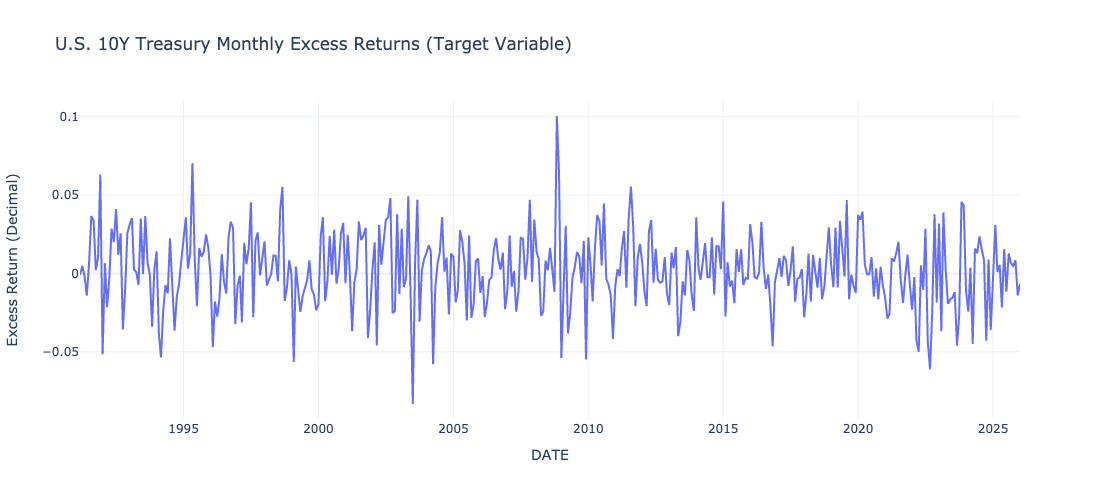

In [15]:
# visualize the target variable to check for volatility clusters or trends
fig = px.line(df_final, y='excess_return', 
                     title='U.S. 10Y Treasury Monthly Excess Returns (Target Variable)',
                     labels={'index': 'Date', 'excess_return': 'Excess Return (Decimal)'},
                     template='plotly_white', height=500, width=1100,)
fig.show(renderer="png")

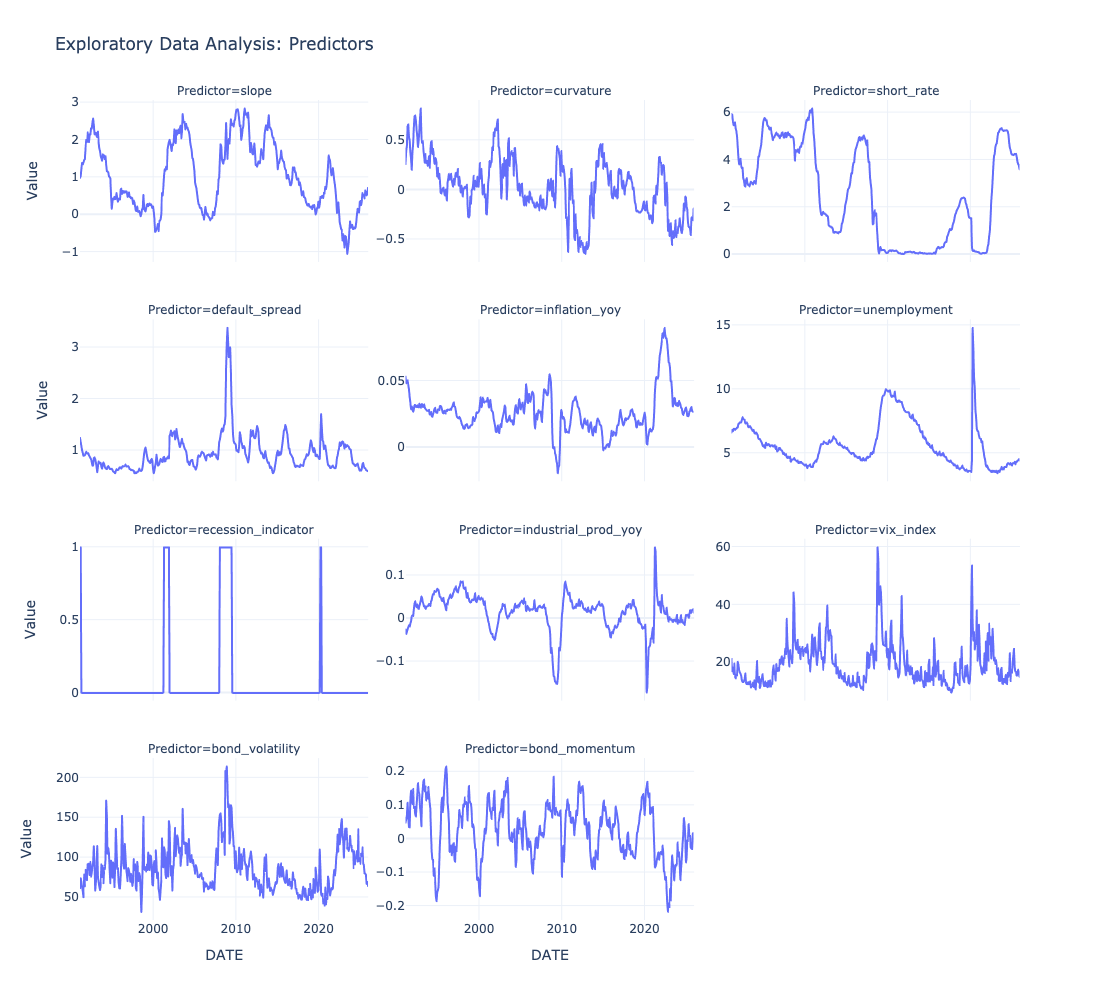

In [16]:
predictors = ['slope', 'curvature', 'short_rate', 'default_spread', 'inflation_yoy', 'unemployment', 
              'recession_indicator', 'industrial_prod_yoy', 'vix_index', 'bond_volatility', 'bond_momentum']

df_long = df_final[predictors].reset_index().melt(
    id_vars='DATE', 
    value_vars=predictors,
    var_name='Predictor', 
    value_name='Value'
)

fig = px.line(
    df_long, 
    x='DATE', 
    y='Value', 
    facet_col='Predictor', 
    facet_col_wrap=3,
    facet_col_spacing=0.04,
    height=1000,
    width=1100,
    title='Exploratory Data Analysis: Predictors',
    template='plotly_white'
)

fig.update_yaxes(matches=None, showticklabels=True)
fig.update_layout(showlegend=False)

fig.show(renderer="png")

We found that the `short_rate` is non-stationary. Thus we need to make it stationary by taking the first difference.

In [17]:
# make short-rate stationary: create the first difference for the short rate
df_final['short_rate_diff'] = df_final['short_rate'].diff()
df_final.dropna(inplace=True) # do not forget to dropna, as diff will make the first row null

In [18]:
stationarity_table = run_stationarity_test(df_final)
stationarity_table

Variable  ADF Statistic  p-value Stationary (5%)
0         excess_return       -14.9696   0.0000             Yes
1                 slope        -2.9467   0.0402             Yes
2             curvature        -3.5987   0.0058             Yes
3            short_rate        -2.7046   0.0733              No
4        default_spread        -4.6117   0.0001             Yes
5         inflation_yoy        -3.6354   0.0051             Yes
6          unemployment        -3.0227   0.0328             Yes
7   recession_indicator        -4.5599   0.0002             Yes
8   industrial_prod_yoy        -3.4588   0.0091             Yes
9             vix_index        -3.6423   0.0050             Yes
10      bond_volatility        -3.2388   0.0178             Yes
11        bond_momentum        -3.7265   0.0038             Yes
12      short_rate_diff        -4.5350   0.0002             Yes

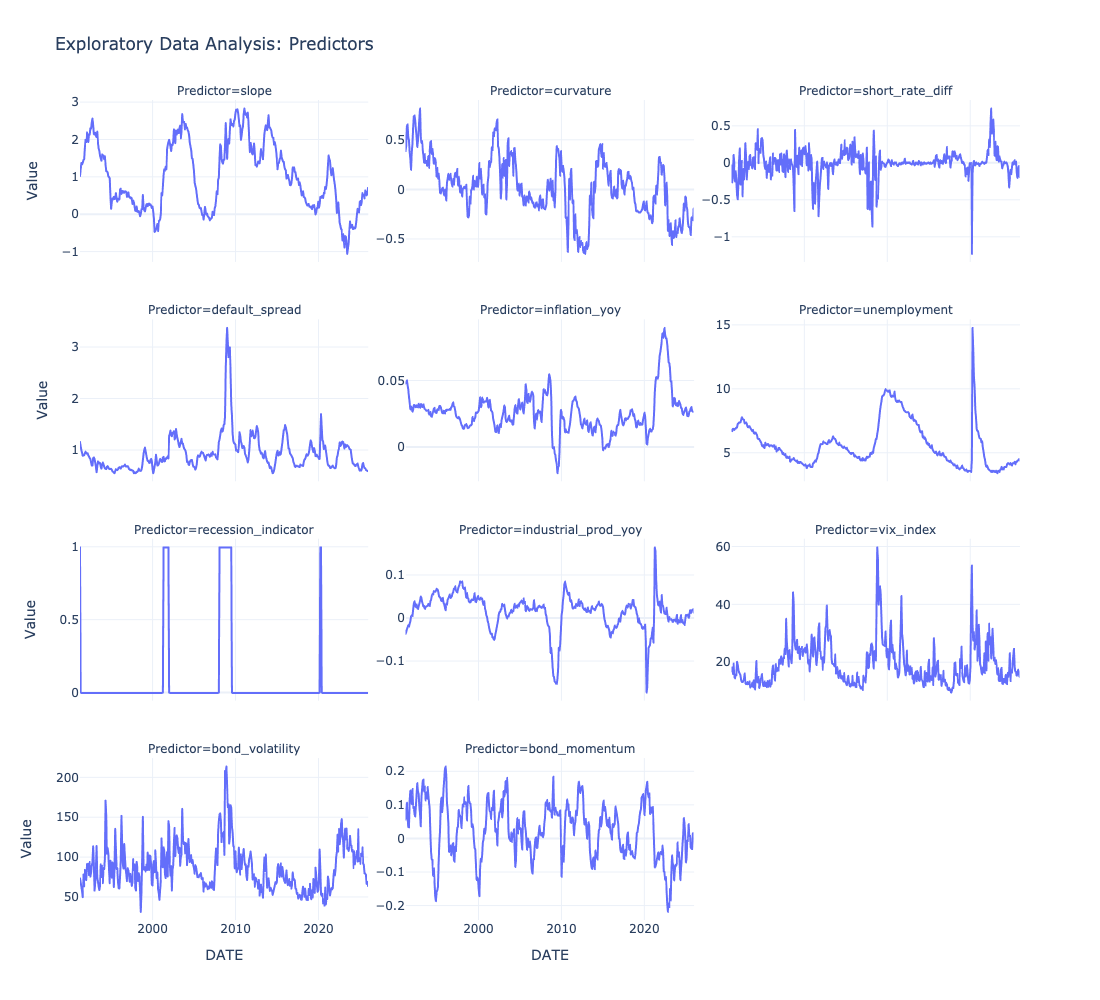

In [19]:
# re-run ADF test
predictors = ['slope', 'curvature', 'short_rate_diff', 'default_spread', 'inflation_yoy', 'unemployment', 
              'recession_indicator', 'industrial_prod_yoy', 'vix_index', 'bond_volatility', 'bond_momentum']

df_long = df_final[predictors].reset_index().melt(
    id_vars='DATE', 
    value_vars=predictors,
    var_name='Predictor', 
    value_name='Value'
)

fig = px.line(
    df_long, 
    x='DATE', 
    y='Value', 
    facet_col='Predictor', 
    facet_col_wrap=3,
    facet_col_spacing=0.04,
    height=1000,
    width=1100,
    title='Exploratory Data Analysis: Predictors',
    template='plotly_white'
)

fig.update_yaxes(matches=None, showticklabels=True)
fig.update_layout(showlegend=False)

fig.show(renderer="png")

### 2.4 Outlier Identification

In [31]:
from scipy.stats import zscore

# Z-scores for each variable
z_scores = np.abs(zscore(df_final))
outliers = (z_scores > 3)

# Identifying outliers
df_outliers = df_final[outliers.any(axis=1)]

Whether you need to remove outliers depends on the goal of your analysis and the characteristics of your data.

*   Remove outliers: When using linear regression (e.g., OLS), outliers can seriously affect the regression coefficients and the fit of the model.
*   Keep outliers: When these outliers reflect real market fluctuations or extreme events (e.g., financial crises, etc.) and robust regression or nonlinear models (e.g., Random Forest, XGBoost) are used, the model is usually more tolerant of outliers.

### 2.5 Statistical Summary of Variables

In [32]:
# Statistical summary
df_final.describe()

excess_return       slope   curvature  short_rate  default_spread  \
count     418.000000  418.000000  418.000000  418.000000      418.000000   
mean        0.002097    1.021770    0.025502    2.559043        0.934019   
std         0.023590    0.922162    0.293590    2.074733        0.369487   
min        -0.083300   -1.060000   -0.650000    0.010000        0.550000   
25%        -0.012015    0.250000   -0.160000    0.195000        0.692500   
50%         0.001950    0.945000    0.025000    2.360000        0.870000   
75%         0.016263    1.850000    0.230000    4.712500        1.050000   
max         0.100383    2.840000    0.820000    6.170000        3.380000   

       inflation_yoy  unemployment  recession_indicator  industrial_prod_yoy  \
count     418.000000    418.000000           418.000000           418.000000   
mean        0.026101      5.672010             0.069378             0.014990   
std         0.015362      1.767725             0.254400             0.041995   
min        -0.019588      3.400000             0.000000            -0.173183   
25%         0.017153      4.300000             0.000000            -0.002724   
50%         0.025875      5.300000             0.000000             0.022888   
75%         0.031538      6.675000             0.000000             0.037698   
max         0.089794     14.800000             1.000000             0.165521   

        vix_index  bond_volatility  bond_momentum  short_rate_diff  
count  418.000000       418.000000     418.000000       418.000000  
mean    19.381507        87.046001       0.026577        -0.005622  
std      7.470776        28.292342       0.082606         0.187748  
min      9.510000        31.294155      -0.218800        -1.230000  
25%     13.752500        66.657501      -0.033681        -0.040000  
50%     17.285000        83.810679       0.033933         0.000000  
75%     23.342500       101.434358       0.086644         0.070000  
max     59.890000       214.000000       0.215275         0.740000

Bond Return Volatility: 0.0236 indicates that the volatility of returns is relatively high, suggesting that excess returns have considerable fluctuations, possibly reflecting market uncertainty.

Macroeconomic Indicators: Variables such as interest rates, credit spreads, inflation, and unemployment exhibit fluctuations across different economic cycles, influencing bond and stock returns.

Volatility Indicators: The mean of bond_volatility is 87.05, which, compared to the VIX, shows that the bond market may be relatively more volatile, especially during times of increased economic uncertainty.

Recession Indicator (recession_indicator): The mean is 0.0694, indicating that the economy is in an expansion phase most of the time, with only about 6.94% of the time in recession.

### 2.6 Correlation and Bivariate Analysis

Check the correlation between variables.

In [20]:
all_cols = ['excess_return'] + ['slope', 'curvature', 'short_rate_diff', 'default_spread', 'inflation_yoy', 'unemployment', 
              'recession_indicator', 'industrial_prod_yoy', 'vix_index', 'bond_volatility', 'bond_momentum']

corr_matrix = df_final[all_cols].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
df_corr_masked = corr_matrix.mask(mask)

fig_heatmap = px.imshow(
    df_corr_masked,
    text_auto=".2f",
    aspect="auto",
    color_continuous_scale='RdBu_r',
    zmin=-1, zmax=1,
    title="Correlation Matrix: US 10Y Treasury Returns & Predictors",
    labels=dict(color="Correlation"),
    height=600,
    width=1100, template='plotly_white'
)
fig_heatmap.show()

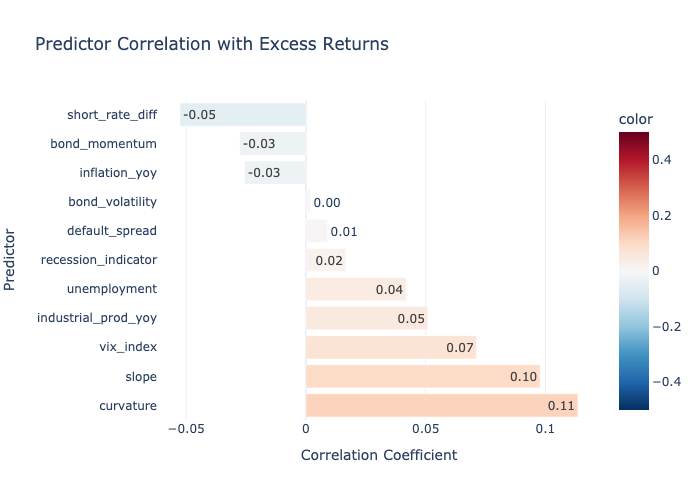

In [21]:
target_corr = corr_matrix['excess_return'].drop('excess_return').sort_values(ascending=False)

fig = px.bar(
    target_corr, 
    orientation='h',
    text_auto=".2f",
    title="Predictor Correlation with Excess Returns",
    labels={'value': 'Correlation Coefficient', 'index': 'Predictor'},
    color=target_corr,
    color_continuous_scale='RdBu_r',
    range_color=[-0.5, 0.5], template='plotly_white'
)
fig.show(renderer="png")

- Some predictors are really highly correlated. For example, `unemployment` and `slope` has a correlation coef of 0.71, and `default_spread` and `industrial_prod_yoy` has a correlation coef of -0.65.
- There is no predictor that has strong correlation with the target variable.

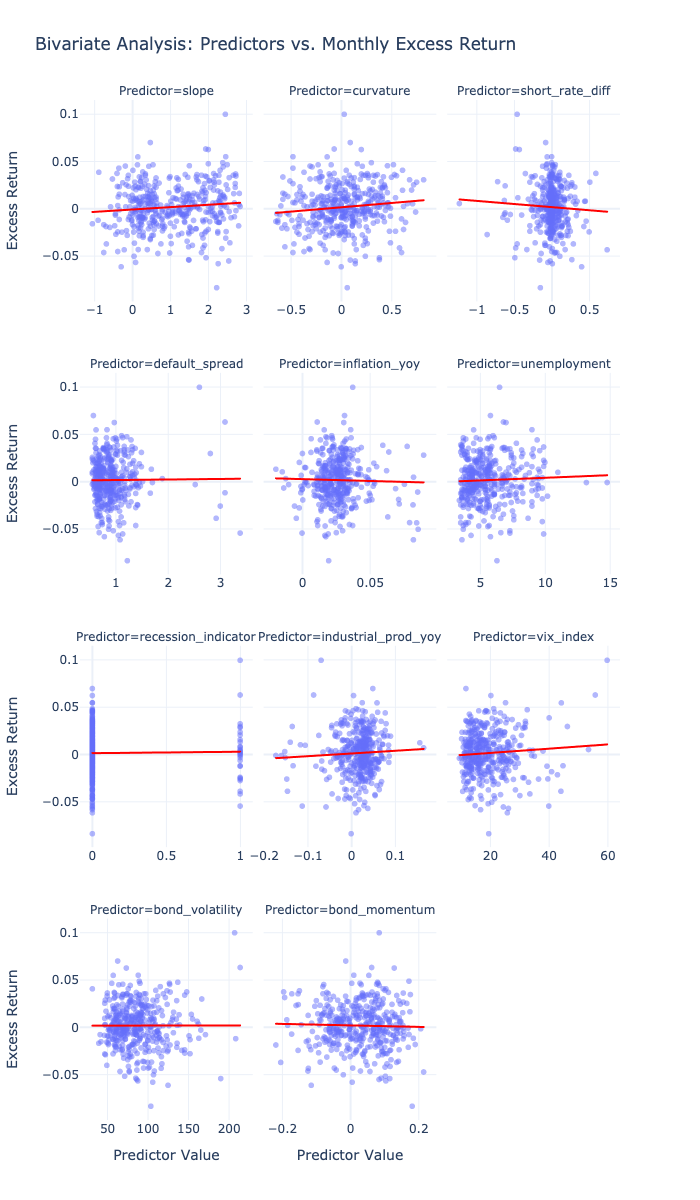

In [22]:
df_bivariate = df_final.melt(
    id_vars=['excess_return'], 
    value_vars=predictors,
    var_name='Predictor', 
    value_name='Value'
)

fig = px.scatter(
    df_bivariate, 
    x='Value', 
    y='excess_return', 
    facet_col='Predictor', 
    facet_col_wrap=3,           # 3 columns for better visibility
    trendline="ols",            # Adds a linear regression line to each plot
    trendline_color_override="red",
    height=1200,
    title="Bivariate Analysis: Predictors vs. Monthly Excess Return",
    labels={'Value': 'Predictor Value', 'excess_return': 'Excess Return'},
    template='plotly_white',
    opacity=0.5                 # Lower opacity helps see density of points
)

# independent x-axis: because units vary (e.g., VIX is ~20, slope is ~1.5)
fig.update_xaxes(matches=None, showticklabels=True)
fig.update_layout(showlegend=False)

fig.show(renderer="png")

From the scatter plot we can see that the data points are widely scattered from the red line, we can say the predictor is noisy.
The signal-to-noise ratio is very low shown by:
- high dipersion
- shallow trendline (nearly horizontal)

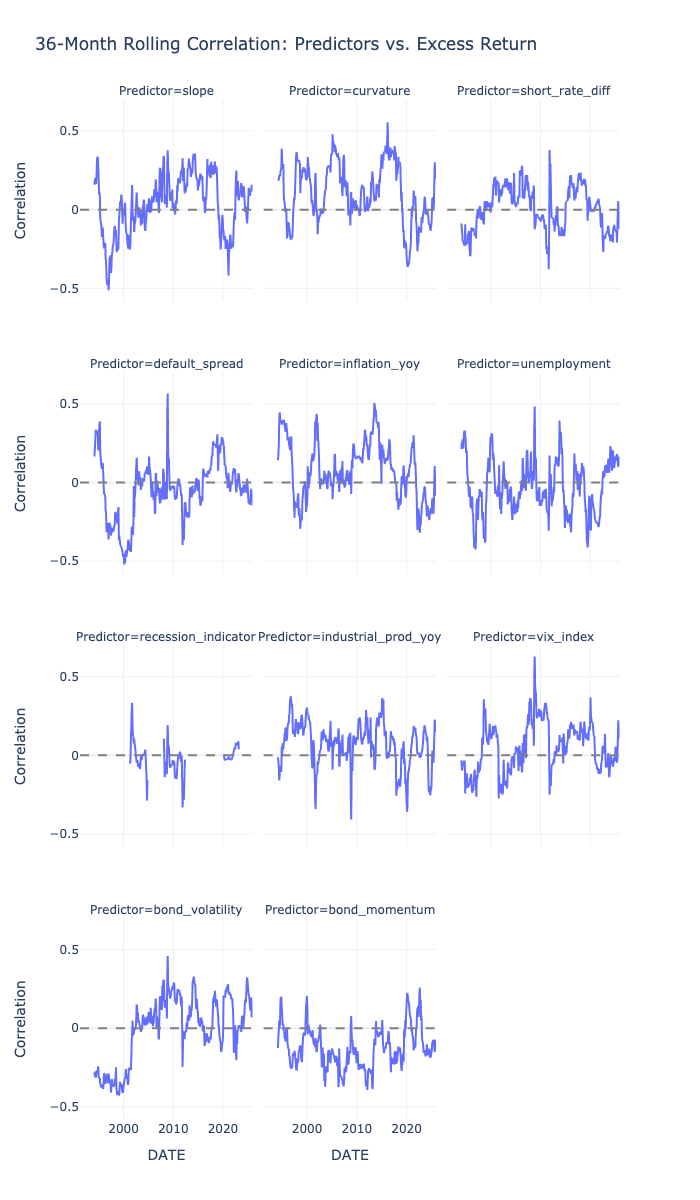

In [23]:
window = 36  # 3-year rolling window

# calculate rolling correlations for all predictors
rolling_corr_list = []
for pred in predictors:
    # corr between target and current predictor
    series = df_final['excess_return'].rolling(window=window).corr(df_final[pred])
    temp_df = series.to_frame(name='Correlation')
    temp_df['Predictor'] = pred
    rolling_corr_list.append(temp_df)

df_rolling = pd.concat(rolling_corr_list).reset_index()

fig = px.line(
    df_rolling, 
    x='DATE', 
    y='Correlation', 
    facet_col='Predictor', 
    facet_col_wrap=3, 
    height=1200,
    title=f"{window}-Month Rolling Correlation: Predictors vs. Excess Return",
    template='plotly_white'
)

fig.add_hline(y=0, line_dash="dash", line_color="gray")
fig.update_layout(showlegend=False)

fig.show(renderer="png")

We use 36-month rolling window for the correaltion so that it is still responsive to economy shift, but still stable (too short window will cause us to catch termporary market noise rather than true structural change). Moreover, cycles usually last several years.

From the plot we can see that the correlations between the target variable and the predictors change over time. Typically, this will cause a simple OLS to fail to capture the complexity (because OLS assumes constant linear relationship). This also align with our previous claim that the signal-to-noise ratio is low, such that the trend/signal of the predictor relative to the target variable is not persistent. ==> **can be our justification for moving toward more flexible models like Random Forest and XGBOOST**

`recession_indicator` is a boolean (true/false) indicator, not a numerical feature.

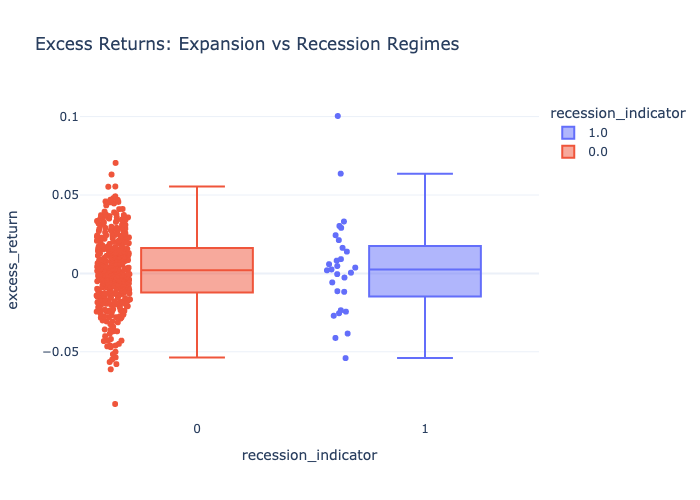

In [24]:
# recession check
fig = px.box(
    df_final, x='recession_indicator', y='excess_return',
    color='recession_indicator',
    title="Excess Returns: Expansion vs Recession Regimes",
    points="all",
    template='plotly_white'
)
fig.show(renderer="png")

### 2.7 Autocorrelation (ACF/PACF)

a. Excess Return (Target Variable)

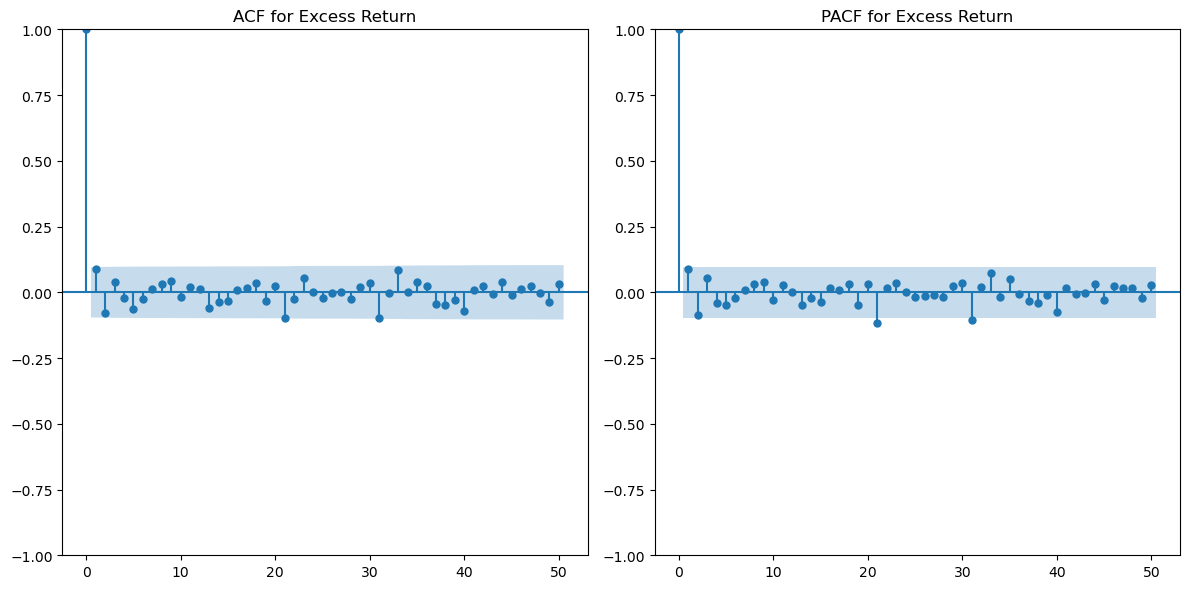

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# ACF/PACF Excess Return
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_acf(df_final['excess_return'].dropna(), ax=plt.gca(), lags=50)
plt.title('ACF for Excess Return')

plt.subplot(1, 2, 2)
plot_pacf(df_final['excess_return'].dropna(), ax=plt.gca(), lags=50)
plt.title('PACF for Excess Return')

plt.tight_layout()
plt.show()

The target variable lag 1 is at the "borderline" of the threshold. So, we take that lag 1 value as predictor in hope that it will give some predictive power even if it is small.

In [26]:
df_final['excess_return_lag1'] = df_final['excess_return'].shift(1)
df_final.dropna(inplace=True)

df_final.head()

excess_return  slope  curvature  short_rate  default_spread  \
DATE                                                                      
1991-05-01      -0.001467   1.22       0.44        5.65            1.08   
1991-06-01      -0.014125   1.38       0.64        5.46            1.00   
1991-07-01       0.005817   1.34       0.66        5.57            0.95   
1991-08-01       0.036592   1.39       0.53        5.58            0.89   
1991-09-01       0.033667   1.46       0.50        5.33            0.90   

            inflation_yoy  unemployment  recession_indicator  \
DATE                                                           
1991-05-01       0.048099           6.7                  0.0   
1991-06-01       0.050349           6.9                  0.0   
1991-07-01       0.046959           6.9                  0.0   
1991-08-01       0.043678           6.8                  0.0   
1991-09-01       0.037994           6.9                  0.0   

            industrial_prod_yoy  vix_index  bond_volatility  bond_momentum  \
DATE                                                                         
1991-05-01            -0.031106      18.24        68.587824       0.068242   
1991-06-01            -0.024950      15.93        62.634572       0.107308   
1991-07-01            -0.020371      19.55        57.423292       0.065158   
1991-08-01            -0.015908      15.18        49.796967       0.035008   
1991-09-01            -0.019345      14.46        78.295990       0.033850   

            short_rate_diff  excess_return_lag1  
DATE                                             
1991-05-01            -0.26            0.004700  
1991-06-01            -0.19           -0.001467  
1991-07-01             0.11           -0.014125  
1991-08-01             0.01            0.005817  
1991-09-01            -0.25            0.036592

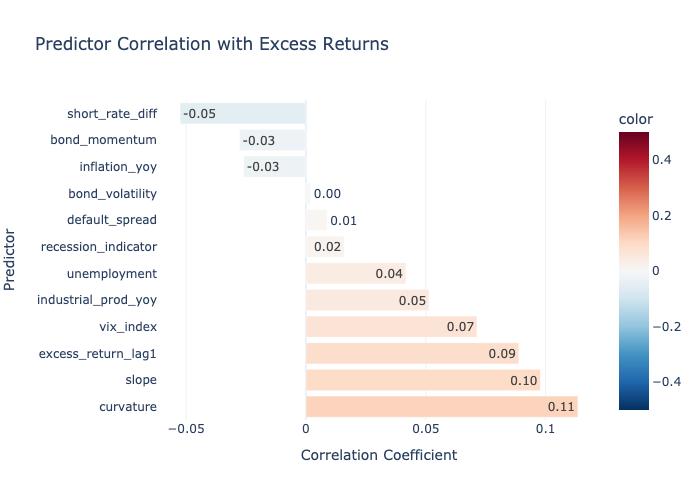

In [27]:
all_cols = ['excess_return', 'excess_return_lag1', 'slope', 'curvature', 'short_rate_diff', 'default_spread', 
            'inflation_yoy', 'unemployment', 'recession_indicator', 'industrial_prod_yoy', 'vix_index',
            'bond_volatility', 'bond_momentum']

corr_matrix = df_final[all_cols].corr()

target_corr = corr_matrix['excess_return'].drop('excess_return').sort_values(ascending=False)

fig = px.bar(
    target_corr,
    orientation='h',
    text_auto=".2f",
    title="Predictor Correlation with Excess Returns",
    labels={'value': 'Correlation Coefficient', 'index': 'Predictor'},
    color=target_corr,
    color_continuous_scale='RdBu_r',
    range_color=[-0.5, 0.5], template='plotly_white'
)
fig.show(renderer="png")

b. Predictors

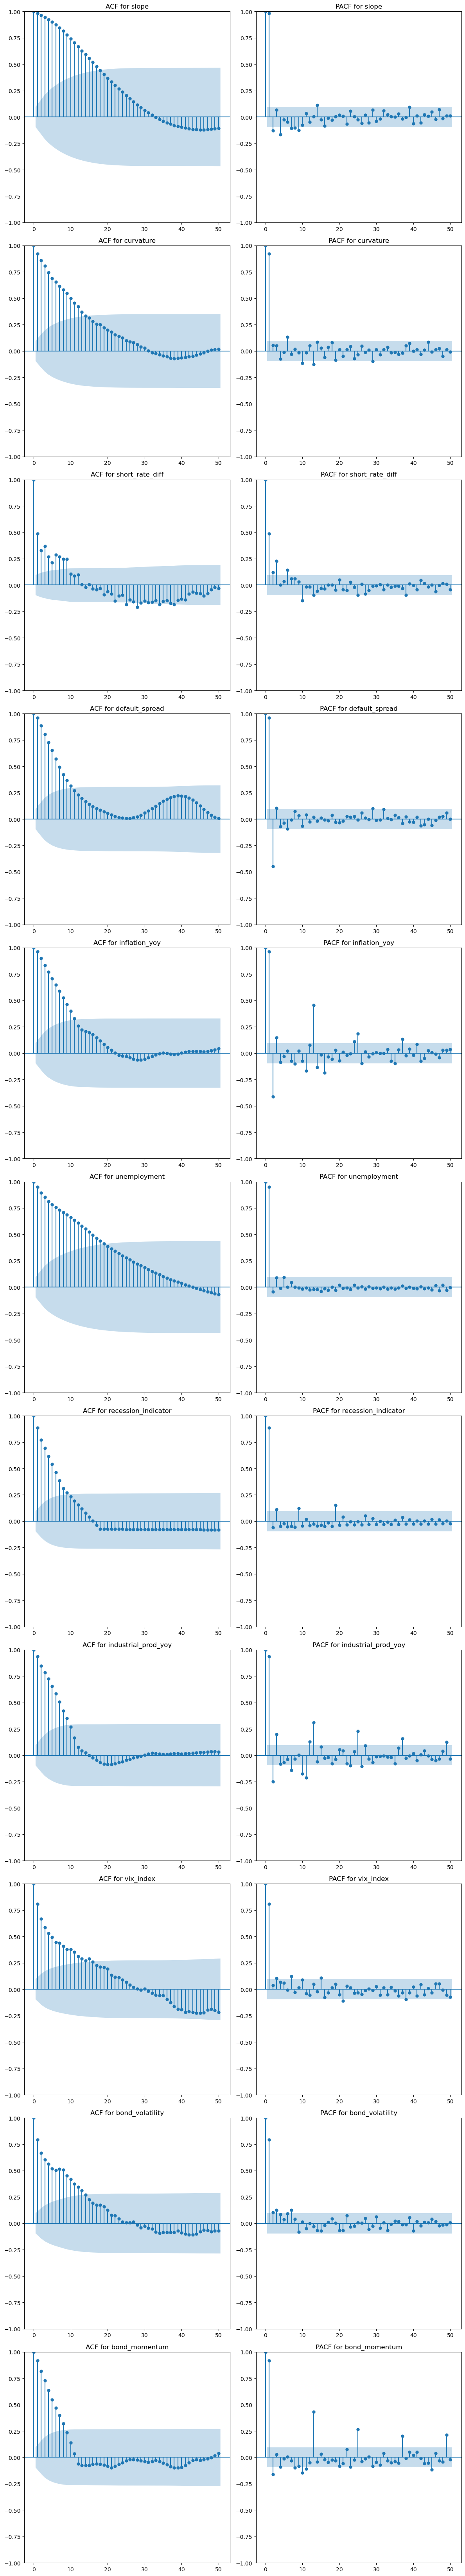

In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# List of predictors to analyze
predictors = ['slope', 'curvature', 'short_rate_diff', 'default_spread', 'inflation_yoy', 'unemployment',
              'recession_indicator', 'industrial_prod_yoy', 'vix_index', 'bond_volatility', 'bond_momentum']

# Create subplots for ACF and PACF of each predictor
fig, axes = plt.subplots(len(predictors), 2, figsize=(12, 6 * len(predictors)))

for i, predictor in enumerate(predictors):
    # ACF plot
    plot_acf(df_final[predictor].dropna(), ax=axes[i, 0], lags=50)
    axes[i, 0].set_title(f'ACF for {predictor}')

    # PACF plot
    plot_pacf(df_final[predictor].dropna(), ax=axes[i, 1], lags=50)
    axes[i, 1].set_title(f'PACF for {predictor}')

plt.tight_layout()
plt.show()


### 2.8 Standardization

make the data to be zero mean and 1 std. this is important for models like OLS (and its variation), and the PCA, because the scale will impact the beta coefficient.

In [29]:
train_size = int(len(df_final) * 0.6)

predictors = ['slope', 'curvature', 'short_rate_diff', 'default_spread', 'inflation_yoy', 'unemployment', 
              'recession_indicator', 'industrial_prod_yoy', 'vix_index', 'bond_volatility', 'bond_momentum',
              'excess_return_lag1']

X_raw = df_final[predictors]
y = df_final['excess_return']

X_train_unscaled = X_raw.iloc[:train_size]
X_test_unscaled = X_raw.iloc[train_size:]
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

# standardize
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train_unscaled)
X_test_standardized = scaler.transform(X_test_unscaled)

X_train_standardized = pd.DataFrame(X_train_standardized, columns=X_raw.columns, index=X_train_unscaled.index)
X_test_standardized = pd.DataFrame(X_test_standardized, columns=X_raw.columns, index=X_test_unscaled.index)

In [30]:
X_train_standardized.head()

slope  curvature  short_rate_diff  default_spread  \
DATE                                                               
1991-05-01  0.028721   1.202947        -1.176153        0.297259   
1991-06-01  0.197419   1.951141        -0.828002        0.113936   
1991-07-01  0.155244   2.025961         0.664073       -0.000642   
1991-08-01  0.207962   1.539634         0.166715       -0.138134   
1991-09-01  0.281768   1.427405        -1.126418       -0.115219   

            inflation_yoy  unemployment  recession_indicator  \
DATE                                                           
1991-05-01       1.978515      0.426246            -0.340693   
1991-06-01       2.179637      0.548101            -0.340693   
1991-07-01       1.876570      0.548101            -0.340693   
1991-08-01       1.583190      0.487174            -0.340693   
1991-09-01       1.074923      0.548101            -0.340693   

            industrial_prod_yoy  vix_index  bond_volatility  bond_momentum  \
DATE                                                                         
1991-05-01            -1.202670  -0.271619        -0.877366       0.309051   
1991-06-01            -1.062294  -0.559241        -1.084698       0.805107   
1991-07-01            -0.957887  -0.108509        -1.266189       0.269900   
1991-08-01            -0.856109  -0.652625        -1.531789      -0.112935   
1991-09-01            -0.934474  -0.742273        -0.539263      -0.127643   

            excess_return_lag1  
DATE                            
1991-05-01            0.033814  
1991-06-01           -0.211408  
1991-07-01           -0.714777  
1991-08-01            0.078219  
1991-09-01            1.302012

In [44]:
X_test_standardized.head()

slope  curvature  short_rate_diff  default_spread  \
DATE                                                               
2012-03-01  0.513727  -2.463205         0.415394        0.778484   
2012-04-01  0.745687  -2.238747         0.067243        0.663907   
2012-05-01  0.513727  -2.612844         0.116979        0.640992   
2012-06-01  0.134157  -2.388386         0.166715        0.732653   
2012-07-01  0.155244  -2.538025         0.116979        0.984724   

            inflation_yoy  unemployment  recession_indicator  \
DATE                                                           
2012-03-01       0.269086      1.401081            -0.340693   
2012-04-01      -0.012849      1.340154            -0.340693   
2012-05-01      -0.289783      1.340154            -0.340693   
2012-06-01      -0.768361      1.340154            -0.340693   
2012-07-01      -0.843536      1.340154            -0.340693   

            industrial_prod_yoy  vix_index  bond_volatility  bond_momentum  \
DATE                                                                         
2012-03-01             0.518977  -0.247962        -0.622707       1.603050   
2012-04-01             0.151726  -0.612781        -0.528675       1.415231   
2012-05-01             0.396948  -0.407337        -1.075454       1.171647   
2012-06-01             0.423054   0.453038        -0.674947       1.306877   
2012-07-01             0.352827  -0.416053        -0.716739       1.394703   

            excess_return_lag1  
DATE                            
2012-03-01           -0.632263  
2012-04-01           -0.984853  
2012-05-01            0.920260  
2012-06-01            1.196964  
2012-07-01           -0.389692

### 2.9 PCA for Dimensionality Reduction

As shown in correlation analysis, we found siginificant multicollinearity between the predictors.

Here, we do PCA to transform the predictors into new orthogonal (uncorrelated) principal components.

In [31]:
# fit PCA on standardized features
pca = PCA()
X_train_pca = pca.fit_transform(X_train_standardized)
X_test_pca = pca.transform(X_test_standardized)

# create a df for the PCs
pc_cols = [f'PC{i+1}' for i in range(len(predictors))]
X_train_pca = pd.DataFrame(X_train_pca, columns=pc_cols, index=X_train_standardized.index)
X_test_pca = pd.DataFrame(X_test_pca, columns=pc_cols, index=X_test_standardized.index)

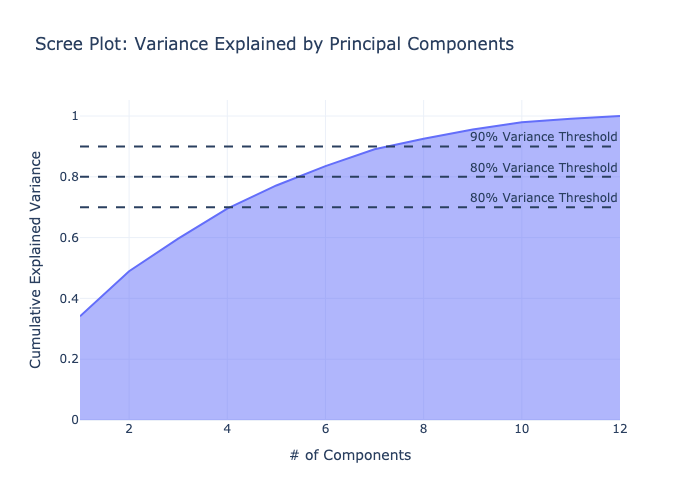

In [46]:
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

fig = px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# of Components", "y": "Cumulative Explained Variance"},
    title="Scree Plot: Variance Explained by Principal Components",
    template='plotly_white'
)
fig.add_hline(y=0.9, line_dash="dash", annotation_text="90% Variance Threshold")
fig.add_hline(y=0.8, line_dash="dash", annotation_text="80% Variance Threshold")
fig.add_hline(y=0.7, line_dash="dash", annotation_text="80% Variance Threshold")
fig.show(renderer="png")
# fig.show()

From the plot, we know can conclude that:
- The first 4 PCs explain ~72% variation of the data
- The first 6 PCs explain ~84% variation of the data
- The first 8 PCs explain ~93% variation of the data

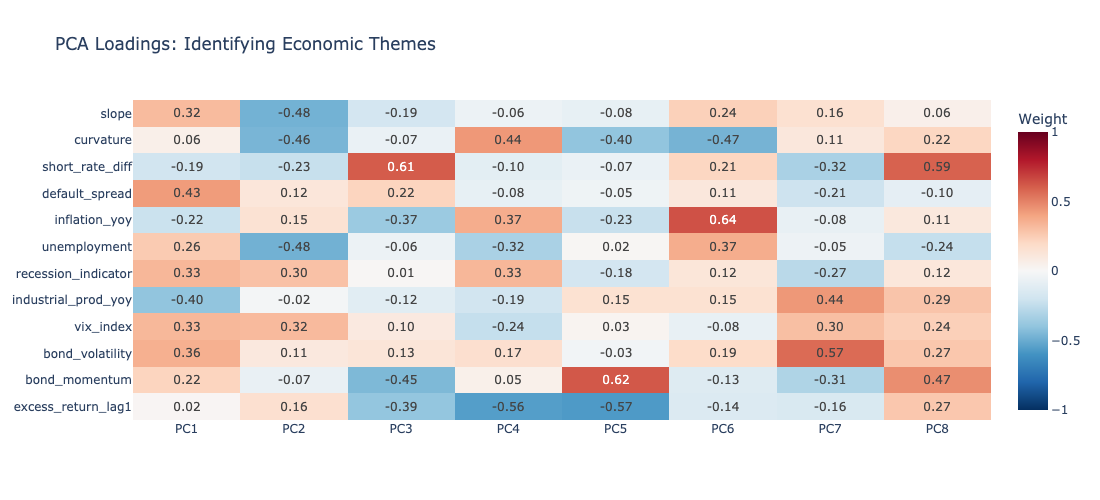

In [32]:
# loadings heatmap: to interpret the components economically 
loadings = pd.DataFrame(
    pca.components_.T, 
    columns=pc_cols, 
    index=predictors
)

fig = px.imshow(
    loadings.iloc[:, :8],
    aspect="auto",
    text_auto=".2f",
    color_continuous_scale='RdBu_r',
    zmin=-1, zmax=1,
    title="PCA Loadings: Identifying Economic Themes",
    labels=dict(color="Weight"), width = 1100, height = 500
)
fig.show(renderer="png")

The above loading heatmaps allow us to understand the correlation of each PC with the raw variables.

Later, we will use this PCA component for modelling. We will compare whether using raw features vs PCs give better predictive result.

| Feature type | Advantage | Trade-off |
|--------------|-----------|-----------|
| Raw Standardized Feature | High Economic Intuition because coefficients are directly linked to variables | Suffering from Multicollinearity. OLS estimates can be unstable and standard errors inflated |
| Principal Components (PCs) | PCs are orthogonal, so help in stabilising model | Not really interprettable |

- **TO DO LATER: analyze how we can interpret the first 5 PCs**

### 2.10 Final Data for Modelling

We now have 2 sets of train data: `X_train_standardized` and `X_train_pca`.

In [48]:
X_train_standardized.head()

slope  curvature  short_rate_diff  default_spread  \
DATE                                                               
1991-05-01  0.028721   1.202947        -1.176153        0.297259   
1991-06-01  0.197419   1.951141        -0.828002        0.113936   
1991-07-01  0.155244   2.025961         0.664073       -0.000642   
1991-08-01  0.207962   1.539634         0.166715       -0.138134   
1991-09-01  0.281768   1.427405        -1.126418       -0.115219   

            inflation_yoy  unemployment  recession_indicator  \
DATE                                                           
1991-05-01       1.978515      0.426246            -0.340693   
1991-06-01       2.179637      0.548101            -0.340693   
1991-07-01       1.876570      0.548101            -0.340693   
1991-08-01       1.583190      0.487174            -0.340693   
1991-09-01       1.074923      0.548101            -0.340693   

            industrial_prod_yoy  vix_index  bond_volatility  bond_momentum  \
DATE                                                                         
1991-05-01            -1.202670  -0.271619        -0.877366       0.309051   
1991-06-01            -1.062294  -0.559241        -1.084698       0.805107   
1991-07-01            -0.957887  -0.108509        -1.266189       0.269900   
1991-08-01            -0.856109  -0.652625        -1.531789      -0.112935   
1991-09-01            -0.934474  -0.742273        -0.539263      -0.127643   

            excess_return_lag1  
DATE                            
1991-05-01            0.033814  
1991-06-01           -0.211408  
1991-07-01           -0.714777  
1991-08-01            0.078219  
1991-09-01            1.302012

In [49]:
X_train_pca.head()

PC1       PC2       PC3       PC4       PC5       PC6  \
DATE                                                                     
1991-05-01  0.141173  0.443516 -1.657617 -1.248347 -0.793751  0.235191   
1991-06-01 -0.039865  1.197136 -1.848503 -1.747593 -0.697300  0.126213   
1991-07-01 -0.406997  1.535512 -0.399320 -1.617439 -0.760425  0.278668   
1991-08-01 -0.718437  1.298752 -0.836445 -0.980672 -1.147690  0.135645   
1991-09-01  0.064644  0.804182 -1.791005 -0.375526 -1.659200 -0.360214   

                 PC7       PC8       PC9      PC10      PC11      PC12  
DATE                                                                    
1991-05-01 -0.832806 -0.888663  1.100189 -1.176633 -0.210985 -0.433317  
1991-06-01 -1.075352 -0.422267  1.269832 -1.132738 -0.134602 -0.605125  
1991-07-01 -1.184293  0.156607  1.770908 -0.875203 -0.352828 -0.464061  
1991-08-01 -1.295693 -0.381841  1.156169 -0.632524 -0.198091 -0.209881  
1991-09-01 -0.535258 -0.686040  0.107016 -0.750513 -0.248185 -0.348828

We now have 2 sets of test data: `X_test_standardized` and `X_test_pca`.

In [50]:
X_test_standardized.head()

slope  curvature  short_rate_diff  default_spread  \
DATE                                                               
2012-03-01  0.513727  -2.463205         0.415394        0.778484   
2012-04-01  0.745687  -2.238747         0.067243        0.663907   
2012-05-01  0.513727  -2.612844         0.116979        0.640992   
2012-06-01  0.134157  -2.388386         0.166715        0.732653   
2012-07-01  0.155244  -2.538025         0.116979        0.984724   

            inflation_yoy  unemployment  recession_indicator  \
DATE                                                           
2012-03-01       0.269086      1.401081            -0.340693   
2012-04-01      -0.012849      1.340154            -0.340693   
2012-05-01      -0.289783      1.340154            -0.340693   
2012-06-01      -0.768361      1.340154            -0.340693   
2012-07-01      -0.843536      1.340154            -0.340693   

            industrial_prod_yoy  vix_index  bond_volatility  bond_momentum  \
DATE                                                                         
2012-03-01             0.518977  -0.247962        -0.622707       1.603050   
2012-04-01             0.151726  -0.612781        -0.528675       1.415231   
2012-05-01             0.396948  -0.407337        -1.075454       1.171647   
2012-06-01             0.423054   0.453038        -0.674947       1.306877   
2012-07-01             0.352827  -0.416053        -0.716739       1.394703   

            excess_return_lag1  
DATE                            
2012-03-01           -0.632263  
2012-04-01           -0.984853  
2012-05-01            0.920260  
2012-06-01            1.196964  
2012-07-01           -0.389692

In [51]:
X_test_pca.head()

PC1       PC2       PC3       PC4       PC5       PC6  \
DATE                                                                     
2012-03-01  0.293410  0.222696 -0.314780  1.390207  2.349479  1.967323   
2012-04-01  0.457043  0.526246 -0.261820  0.983642  2.348756  1.691487   
2012-05-01  0.157271 -0.035839 -0.784161  2.500377  1.396145  1.325102   
2012-06-01  0.637520 -0.396338 -0.539263  2.859518  1.381417  0.796725   
2012-07-01  0.484596  0.063387  0.024583  1.868288  2.376365  1.104725   

                 PC7       PC8       PC9      PC10      PC11      PC12  
DATE                                                                    
2012-03-01 -1.096743 -0.181791 -0.024276 -0.022655  0.392165  0.029304  
2012-04-01 -0.976761 -0.682569 -0.286349 -0.000935  0.322732  0.265679  
2012-05-01 -1.416845 -0.399767 -0.449847  0.197016  0.376756  0.250784  
2012-06-01 -1.035031  0.059064 -0.218487  0.166857  0.166611 -0.132218  
2012-07-01 -1.171358 -0.665399 -0.485986  0.162077  0.546764 -0.085495

This a target variable `y`.

In [52]:
y_train.head()

DATE
1991-05-01   -0.001467
1991-06-01   -0.014125
1991-07-01    0.005817
1991-08-01    0.036592
1991-09-01    0.033667
Freq: MS, Name: excess_return, dtype: float64

In [53]:
y_test.head()

DATE
2012-03-01   -0.020917
2012-04-01    0.026992
2012-05-01    0.033950
2012-06-01   -0.005950
2012-07-01    0.015708
Freq: MS, Name: excess_return, dtype: float64

## Benchmark: expanding window naive mean
The benchmark forecast at time t is the historical mean of excess returns computed over all observations available up to t−1 (expanding window).

This choice reflects the standard no-predictability null in return forecasting and allows the unconditional mean to adjust gradually over time, which is appropriate in a time-series setting where bond risk premia may shift across regimes.

In [33]:
# Keep time order (no look-ahead)
X = df_final[predictors].sort_index()
y = y

initial_train_size = int(len(y) * 0.6)

y_true = []
y_bench = []

# Expanding-window mean benchmark: forecast at t is mean(y[0:t])
for t in range(initial_train_size, len(y)):
    y_train = y.iloc[:t]
    y_test = y.iloc[t]

    y_true.append(y_test)
    y_bench.append(y_train.mean())

y_true_oos = np.asarray(y_true)
y_bench_oos = np.asarray(y_bench)

mse_bench = np.mean((y_true_oos - y_bench_oos) ** 2)
rmse_bench = np.sqrt(mse_bench)
hit_ratio_benchmark = np.mean(np.sign(y_true_oos) == np.sign(y_bench_oos))

print(f"Expanding-window benchmark RMSE:{rmse_bench:.6f}")
print("Benchmark OOS R²: 0.00% (by definition)")
print(f"OOS Hit Ratio (Sign Accuracy): {hit_ratio_benchmark:.2%}")

Expanding-window benchmark RMSE:0.021040
Benchmark OOS R²: 0.00% (by definition)
OOS Hit Ratio (Sign Accuracy): 47.90%


## Ridge & Lasso

In [34]:
def calculate_metrics(y_true, y_pred, y_bench):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    y_bench = np.asarray(y_bench, dtype=float)

    # oos r square
    sse_model = np.sum((y_true - y_pred) ** 2)
    sse_bench = np.sum((y_true - y_bench) ** 2)
    oos_r2 = 1 - sse_model / sse_bench

    # hit ratio
    hit_ratio = np.mean(np.sign(y_true) == np.sign(y_pred))

    # rmse
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))

    return oos_r2, hit_ratio, rmse

### V1: Rolling standardized data

In [35]:
def expanding_oos_cv(
    df_model,
    feature_cols,
    y_col="excess_return",
    model_name="ridge",
    initial_train=120,
    #step=1,                     # one-step-ahead
    n_splits=5,                 # inner CV TimeSeriesSplit）
    alphas=None,                # lambda grid
    l1_ratios=None              # only for elastic net
):
    """
    Expanding window one-step-ahead forecasting:
    Outer loop: expanding train, predict next month.
    Inner loop: GridSearchCV + TimeSeriesSplit on training set to select best regularization (alpha / l1_ratio).
    """
    if alphas is None:
        alphas = np.logspace(-4, 2, 30)

    X_all = df_model[feature_cols]
    y_all = df_model[y_col]

    n = len(df_model)

    # store results
    oos_dates = []
    y_true_list, y_pred_list, y_bench_list = [], [], []
    best_params_list = []

    # expanding window outer loop
    for t in range(initial_train, n):
        # train_idx = np.arange(0, t)         # expanding
        # test_idx  = np.arange(t, t + 1)     # next month (one-step)

        X_train, y_train = X_all.iloc[:t], y_all.iloc[:t]
        X_test,  y_test  = X_all.iloc[t:t+1],  y_all.iloc[t:t+1]

        # benchmark: expanding mean forecast based on training y
        y_bench = float(np.mean(y_train))

        # pipeline: scaler fitted ONLY on training folds
        if model_name.lower() == "ridge":
            base_model = Ridge(random_state=42)
            param_grid = {"model__alpha": alphas}
        elif model_name.lower() == "lasso":
            # Lasso max_iter：since Lasso is sensitive to shrinkage, we use higher max_iter
            base_model = Lasso(max_iter=100000, random_state=42)
            param_grid = {"model__alpha": alphas}
        elif model_name.lower() == "elasticnet":
            base_model = ElasticNet(max_iter=100000, random_state=42)
            if l1_ratios is None:
                l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]
            param_grid = {
                "model__alpha": alphas,
                "model__l1_ratio": l1_ratios
            }
        else:
            raise ValueError("model_name ridge / lasso / elasticnet")

        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("model", base_model)
        ])

        # inner TS CV: only within training set
        tscv = TimeSeriesSplit(n_splits=n_splits)

        # 用 MSE 做目标（越小越好）；GridSearchCV 默认是越大越好，所以用 neg MSE：MSE smaller the better, but GridSearchCV is bigger MSE the better, so we use neg MSE
        gscv = GridSearchCV(
            estimator=pipe,
            param_grid=param_grid,
            scoring="neg_mean_squared_error",
            cv=tscv,
            n_jobs=-1
        )
        gscv.fit(X_train, y_train)

        # one-step prediction
        y_hat = float(gscv.predict(X_test)[0])

        # store
        oos_dates.append(df_model.index[t:t+1][0])
        y_true_list.append(float(y_test.iloc[0]))
        y_pred_list.append(y_hat)
        y_bench_list.append(y_bench)
        best_params_list.append(gscv.best_params_)

    # summary
    y_true_arr = np.array(y_true_list)
    y_pred_arr = np.array(y_pred_list)
    y_bench_arr = np.array(y_bench_list)

    # oos_r2 = oos_r2_vs_benchmark(y_true_arr, y_pred_arr, y_bench_arr)
    # rmse = float(np.sqrt(mean_squared_error(y_true_arr, y_pred_arr)))

    oos_r2, hit_ratio, rmse = calculate_metrics(y_true_arr, y_pred_arr, y_bench_arr)

    pred_df = pd.DataFrame({
        "date": oos_dates,
        "y_true": y_true_arr,
        "y_pred": y_pred_arr,
        "y_bench_expanding_mean": y_bench_arr
    }).set_index("date")

    # return {
    #     "model": model_name,
    #     "oos_r2": float(oos_r2),
    #     "rmse": rmse,
    #     "predictions": pred_df,
    #     "best_params_over_time": pd.DataFrame(best_params_list, index=pred_df.index)
    # }
    return {"oos_r2": oos_r2, "hit_ratio": hit_ratio, "rmse": rmse, 
            "predictions": pred_df,
            "best_params_over_time": pd.DataFrame(best_params_list, index=pred_df.index)}

In [36]:
# run 3 models
# X = df_final[predictors].sort_index()
# y = df_final.loc[X.index, 'excess_return']

initial_train_size = int(len(X) * 0.6)

alphas_grid = np.logspace(-4, 2, 30)

ridge_res = expanding_oos_cv(
    df_model=df_final,
    feature_cols=predictors,
    model_name="ridge",
    initial_train=initial_train_size,
    n_splits=5,
    alphas=alphas_grid
)

lasso_res = expanding_oos_cv(
    df_model=df_final,
    feature_cols=predictors,
    model_name="lasso",
    initial_train=initial_train_size,
    n_splits=5,
    alphas=alphas_grid
)

enet_res = expanding_oos_cv(
    df_model=df_final,
    feature_cols=predictors,
    model_name="elasticnet",
    initial_train=initial_train_size,
    n_splits=5,
    alphas=alphas_grid,
    l1_ratios=[0.1, 0.3, 0.5, 0.7, 0.9]
)

# performance summary
summary = pd.DataFrame([
    {"Model": "Ridge",      "OOS_R2": ridge_res["oos_r2"], "RMSE": ridge_res["rmse"], "Hit ratio": ridge_res["hit_ratio"]},
    {"Model": "Lasso",      "OOS_R2": lasso_res["oos_r2"], "RMSE": lasso_res["rmse"], "Hit ratio": lasso_res["hit_ratio"]},
    {"Model": "ElasticNet", "OOS_R2": enet_res["oos_r2"],  "RMSE": enet_res["rmse"], "Hit ratio": enet_res["hit_ratio"]}
]).set_index("Model")

print(summary)

              OOS_R2      RMSE  Hit ratio
Model                                    
Ridge      -0.024537  0.021296   0.568862
Lasso       0.000000  0.021040   0.479042
ElasticNet  0.000000  0.021040   0.479042


In [ ]:
# 看看每期选到的 lambda / l1_ratio 随时间怎么变：show how parameters change over different period
print(ridge_res["best_params_over_time"].tail())
print(lasso_res["best_params_over_time"].tail())
print(enet_res["best_params_over_time"].tail())

            model__alpha
date                    
2025-09-01         100.0
2025-10-01         100.0
2025-11-01         100.0
2025-12-01         100.0
2026-01-01         100.0
            model__alpha
date                    
2025-09-01      0.007279
2025-10-01      0.007279
2025-11-01      0.007279
2025-12-01      0.007279
2026-01-01      0.007279
            model__alpha  model__l1_ratio
date                                     
2025-09-01      0.011721              0.5
2025-10-01      0.011721              0.5
2025-11-01      0.011721              0.5
2025-12-01      0.018874              0.3
2026-01-01      0.011721              0.5


### V2: Rolling PCA (6 PCs)

In [38]:
def expanding_oos_pca_cv(
    df_model,
    feature_cols,
    y_col="excess_return",
    model_name="ridge",
    initial_train=120,
    #step=1,                     # one-step-ahead
    n_splits=5,                 # inner CV TimeSeriesSplit）
    alphas=None,                # lambda grid
    l1_ratios=None,              # only for elastic net
    n_components = 6
):
    """
    Expanding window one-step-ahead forecasting:
    Outer loop: expanding train, predict next month.
    Inner loop: GridSearchCV + TimeSeriesSplit on training set to select best regularization (alpha / l1_ratio).
    """
    if alphas is None:
        alphas = np.logspace(-4, 2, 30)

    X_all = df_model[feature_cols]
    y_all = df_model[y_col]

    n = len(df_model)

    # store results
    oos_dates = []
    y_true_list, y_pred_list, y_bench_list = [], [], []
    best_params_list = []

    # expanding window outer loop
    for t in range(initial_train, n):
        # train_idx = np.arange(0, t)         # expanding
        # test_idx  = np.arange(t, t + 1)     # next month (one-step)

        X_train, y_train = X_all.iloc[:t], y_all.iloc[:t]
        X_test,  y_test  = X_all.iloc[t:t+1],  y_all.iloc[t:t+1]

        # benchmark: expanding mean forecast based on training y
        y_bench = float(np.mean(y_train))

        # pipeline: scaler fitted ONLY on training folds
        if model_name.lower() == "ridge":
            base_model = Ridge(random_state=42)
            param_grid = {"model__alpha": alphas}
        elif model_name.lower() == "lasso":
            # Lasso max_iter：since Lasso is sensitive to shrinkage, we use higher max_iter
            base_model = Lasso(max_iter=100000, random_state=42)
            param_grid = {"model__alpha": alphas}
        elif model_name.lower() == "elasticnet":
            base_model = ElasticNet(max_iter=100000, random_state=42)
            if l1_ratios is None:
                l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]
            param_grid = {
                "model__alpha": alphas,
                "model__l1_ratio": l1_ratios
            }
        else:
            raise ValueError("model_name ridge / lasso / elasticnet")

        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("pca", PCA(n_components=n_components)),
            ("model", base_model)
        ])

        # inner TS CV: only within training set
        tscv = TimeSeriesSplit(n_splits=n_splits)

        # 用 MSE 做目标（越小越好）；GridSearchCV 默认是越大越好，所以用 neg MSE：MSE smaller the better, but GridSearchCV is bigger MSE the better, so we use neg MSE
        gscv = GridSearchCV(
            estimator=pipe,
            param_grid=param_grid,
            scoring="neg_mean_squared_error",
            cv=tscv,
            n_jobs=-1
        )
        gscv.fit(X_train, y_train)

        # one-step prediction
        y_hat = float(gscv.predict(X_test)[0])

        # store
        oos_dates.append(df_model.index[t:t+1][0])
        y_true_list.append(float(y_test.iloc[0]))
        y_pred_list.append(y_hat)
        y_bench_list.append(y_bench)
        best_params_list.append(gscv.best_params_)

    # summary
    y_true_arr = np.array(y_true_list)
    y_pred_arr = np.array(y_pred_list)
    y_bench_arr = np.array(y_bench_list)

    # oos_r2 = oos_r2_vs_benchmark(y_true_arr, y_pred_arr, y_bench_arr)
    # rmse = float(np.sqrt(mean_squared_error(y_true_arr, y_pred_arr)))

    oos_r2, hit_ratio, rmse = calculate_metrics(y_true_arr, y_pred_arr, y_bench_arr)

    pred_df = pd.DataFrame({
        "date": oos_dates,
        "y_true": y_true_arr,
        "y_pred": y_pred_arr,
        "y_bench_expanding_mean": y_bench_arr
    }).set_index("date")

    # return {
    #     "model": model_name,
    #     "oos_r2": float(oos_r2),
    #     "rmse": rmse,
    #     "predictions": pred_df,
    #     "best_params_over_time": pd.DataFrame(best_params_list, index=pred_df.index)
    # }
    return {"oos_r2": oos_r2, "hit_ratio": hit_ratio, "rmse": rmse, 
            "predictions": pred_df,
            "best_params_over_time": pd.DataFrame(best_params_list, index=pred_df.index)}

In [39]:
# run 3 models
# X = df_final[predictors].sort_index()
# y = df_final.loc[X.index, 'excess_return']

initial_train_size = int(len(X) * 0.6)

alphas_grid = np.logspace(-4, 2, 30)

ridge_pca6_res = expanding_oos_pca_cv(
    df_model=df_final,
    feature_cols=predictors,
    model_name="ridge",
    initial_train=initial_train_size,
    n_splits=5,
    alphas=alphas_grid,
    n_components=6
)

lasso_pca6_res = expanding_oos_pca_cv(
    df_model=df_final,
    feature_cols=predictors,
    model_name="lasso",
    initial_train=initial_train_size,
    n_splits=5,
    alphas=alphas_grid,
    n_components=6
)

enet_pca6_res = expanding_oos_pca_cv(
    df_model=df_final,
    feature_cols=predictors,
    model_name="elasticnet",
    initial_train=initial_train_size,
    n_splits=5,
    alphas=alphas_grid,
    l1_ratios=[0.1, 0.3, 0.5, 0.7, 0.9],
    n_components=6
)

# performance summary
summary_pca6 = pd.DataFrame([
    {"Model": "Ridge + PCA",      "OOS_R2": ridge_pca6_res["oos_r2"], "RMSE": ridge_pca6_res["rmse"], "Hit ratio": ridge_pca6_res["hit_ratio"]},
    {"Model": "Lasso + PCA",      "OOS_R2": lasso_pca6_res["oos_r2"], "RMSE": lasso_pca6_res["rmse"], "Hit ratio": lasso_pca6_res["hit_ratio"]},
    {"Model": "ElasticNet + PCA", "OOS_R2": enet_pca6_res["oos_r2"],  "RMSE": enet_pca6_res["rmse"], "Hit ratio": enet_pca6_res["hit_ratio"]}
]).set_index("Model")

print(summary_pca6)

                    OOS_R2      RMSE  Hit ratio
Model                                          
Ridge + PCA      -0.011243  0.021158   0.556886
Lasso + PCA       0.000000  0.021040   0.479042
ElasticNet + PCA  0.000000  0.021040   0.479042


### V3: Rolling PCA (8 PCs)

In [40]:
# run 3 models
# X = df_final[predictors].sort_index()
# y = df_final.loc[X.index, 'excess_return']

initial_train_size = int(len(X) * 0.6)

alphas_grid = np.logspace(-4, 2, 30)

ridge_pca8_res = expanding_oos_pca_cv(
    df_model=df_final,
    feature_cols=predictors,
    model_name="ridge",
    initial_train=initial_train_size,
    n_splits=5,
    alphas=alphas_grid,
    n_components=8
)

lasso_pca8_res = expanding_oos_pca_cv(
    df_model=df_final,
    feature_cols=predictors,
    model_name="lasso",
    initial_train=initial_train_size,
    n_splits=5,
    alphas=alphas_grid,
    n_components=8
)

enet_pca8_res = expanding_oos_pca_cv(
    df_model=df_final,
    feature_cols=predictors,
    model_name="elasticnet",
    initial_train=initial_train_size,
    n_splits=5,
    alphas=alphas_grid,
    l1_ratios=[0.1, 0.3, 0.5, 0.7, 0.9],
    n_components=8
)

# performance summary
summary_pca8 = pd.DataFrame([
    {"Model": "Ridge + PCA",      "OOS_R2": ridge_pca8_res["oos_r2"], "RMSE": ridge_pca8_res["rmse"], "Hit ratio": ridge_pca8_res["hit_ratio"]},
    {"Model": "Lasso + PCA",      "OOS_R2": lasso_pca8_res["oos_r2"], "RMSE": lasso_pca8_res["rmse"], "Hit ratio": lasso_pca8_res["hit_ratio"]},
    {"Model": "ElasticNet + PCA", "OOS_R2": enet_pca8_res["oos_r2"],  "RMSE": enet_pca8_res["rmse"], "Hit ratio": enet_pca8_res["hit_ratio"]}
]).set_index("Model")

print(summary_pca8)

                    OOS_R2      RMSE  Hit ratio
Model                                          
Ridge + PCA      -0.008099  0.021125   0.574850
Lasso + PCA       0.000000  0.021040   0.479042
ElasticNet + PCA  0.000000  0.021040   0.479042


In [ ]:
# 看看每期选到的 lambda / l1_ratio 随时间怎么变：show how parameters change over different period
print(ridge_pca8_res["best_params_over_time"].tail())
print(lasso_pca8_res["best_params_over_time"].tail())
print(enet_pca8_res["best_params_over_time"].tail())

            model__alpha
date                    
2025-09-01         100.0
2025-10-01         100.0
2025-11-01         100.0
2025-12-01         100.0
2026-01-01         100.0
            model__alpha
date                    
2025-09-01      0.007279
2025-10-01      0.007279
2025-11-01      0.007279
2025-12-01      0.004520
2026-01-01      0.007279
            model__alpha  model__l1_ratio
date                                     
2025-09-01      0.007279              0.9
2025-10-01      0.011721              0.5
2025-11-01      0.011721              0.5
2025-12-01      0.018874              0.3
2026-01-01      0.007279              0.9


Exception ignored in: <function ResourceTracker.__del__ at 0x106165c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104f71c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x105029c60>
Traceback (most recent call last

### Ridge 8 PCs – predicted returns vs actual returns

In [41]:
# Ridge + PCA(8) predictions
pred_df = ridge_pca8_res["predictions"]

y_pred_oos = pred_df["y_pred"].to_numpy()

# OOS date index must match benchmark loop
oos_index = X.index[initial_train_size:]


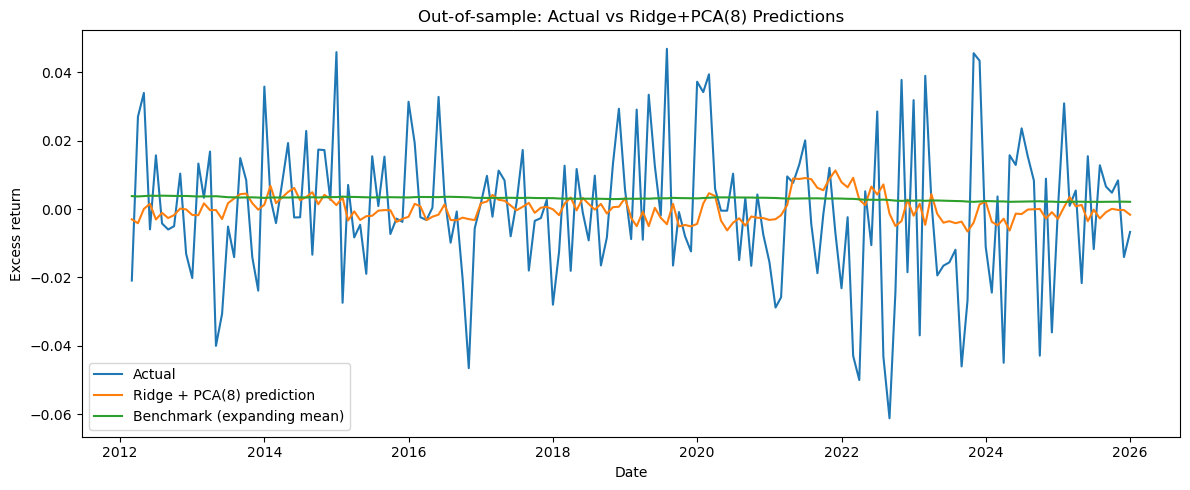

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(oos_index, y_true_oos, label="Actual")
plt.plot(oos_index, y_pred_oos, label="Ridge + PCA(8) prediction")
plt.plot(oos_index, y_bench_oos, label="Benchmark (expanding mean)")
plt.title("Out-of-sample: Actual vs Ridge+PCA(8) Predictions")
plt.xlabel("Date")
plt.ylabel("Excess return")
plt.legend()
plt.tight_layout()
plt.show()


The plot shows that the actual monthly excess returns are highly volatile, with large positive and negative swings, while both the Ridge + PCA(8) predictions and the expanding-mean benchmark are much smoother and close to zero. The Ridge model moves somewhat with medium-term fluctuations but does not capture the large spikes in realized returns.

In terms of metrics, the model slightly improves directional accuracy (hit ratio ≈ 57% vs. 48% for the benchmark), but it does not improve forecast precision: its RMSE is slightly worse than the benchmark and the OOS R² is negative (−0.008), indicating that it performs marginally worse than the expanding-mean forecast in squared-error terms.

Overall, the model shows modest directional signal but no meaningful improvement in magnitude forecasting relative to the benchmark.

### Ridge 8 PCs – Trading strategy

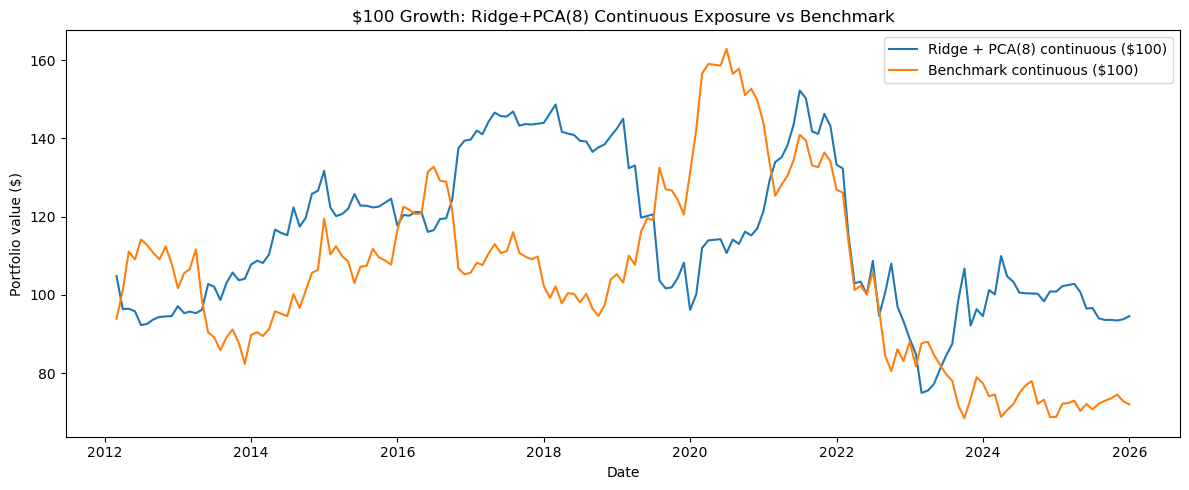

In [43]:
gamma = 3.0
lev_cap = 3.0

sigma2 = np.var(y_true_oos, ddof=1)

# Continuous weights
w_ridge = y_pred_oos / (gamma * sigma2)
w_bench = y_bench_oos / (gamma * sigma2)

w_ridge = np.clip(w_ridge, -lev_cap, lev_cap)
w_bench = np.clip(w_bench, -lev_cap, lev_cap)

# Strategy returns
ret_ridge = w_ridge * y_true_oos
ret_bench = w_bench * y_true_oos

initial_capital = 100.0
wealth_ridge = initial_capital * np.cumprod(1.0 + ret_ridge)
wealth_bench = initial_capital * np.cumprod(1.0 + ret_bench)

plt.figure(figsize=(12, 5))
plt.plot(oos_index, wealth_ridge, label="Ridge + PCA(8) continuous ($100)")
plt.plot(oos_index, wealth_bench, label="Benchmark continuous ($100)")
plt.title("$100 Growth: Ridge+PCA(8) Continuous Exposure vs Benchmark")
plt.xlabel("Date")
plt.ylabel("Portfolio value ($)")
plt.legend()
plt.tight_layout()
plt.show()


The $100 growth plot compares continuous exposure strategies based on Ridge + PCA(8) forecasts versus the expanding-mean benchmark. The Ridge-based strategy outperforms the benchmark for much of the sample, particularly from roughly 2013–2018 and again around 2021, suggesting that the model captures some time-varying risk premia during those periods.

However, both strategies experience large drawdowns around 2022, reflecting the sharp bond market reversal, and the performance gap narrows afterward. While the Ridge strategy ends above the benchmark in cumulative terms, the path is volatile and the advantage is not monotonic, indicating that gains are period-specific rather than consistently strong across the full sample.

Overall, the model appears to add some economic value relative to the expanding-mean benchmark under continuous allocation, but the performance remains sensitive to major market regimes.

 ### Ridge 8 PCs – Certainty equivalent utility gains

In [44]:
def utility_gain(y_true, y_hat, y_bench, gamma=5, cap=1.0, cost_bps=10.0):

    sigma2 = np.var(y_true, ddof=1)

    w_hat = y_hat / (gamma * sigma2)
    w_bench = y_bench / (gamma * sigma2)

    w_hat = np.clip(w_hat, -cap, cap)
    w_bench = np.clip(w_bench, -cap, cap)

    rp_hat = w_hat * y_true
    rp_bench = w_bench * y_true

    if cost_bps > 0:
        tc_hat = (cost_bps / 10000.0) * np.abs(np.diff(w_hat, prepend=w_hat[0]))
        tc_bench = (cost_bps / 10000.0) * np.abs(np.diff(w_bench, prepend=w_bench[0]))

        rp_hat -= tc_hat
        rp_bench -= tc_bench

    CE_hat = np.mean(rp_hat) - 0.5 * gamma * np.var(rp_hat, ddof=1)
    CE_bench = np.mean(rp_bench) - 0.5 * gamma * np.var(rp_bench, ddof=1)

    return 12 * (CE_hat - CE_bench)

for g in [3, 5, 10]:
    delta_ce = utility_gain(y_true_oos, y_pred_oos, y_bench_oos,
                            gamma=g, cap=1.0, cost_bps=10.0)
    print(f"Gamma {g} | Annualized ΔCE (10 bps costs): {delta_ce:.4f}")

Gamma 3 | Annualized ΔCE (10 bps costs): 0.0154
Gamma 5 | Annualized ΔCE (10 bps costs): 0.0120
Gamma 10 | Annualized ΔCE (10 bps costs): -0.0007


The certainty-equivalent results indicate that the Ridge + PCA(8) strategy generates economically meaningful gains for moderately risk-averse investors. For γ = 3 and γ = 5, the annualized certainty-equivalent gains are approximately 1.5% and 1.2% per year, respectively, even after 10 basis points of transaction costs. This suggests that an investor with moderate risk aversion would be willing to pay over 1% per year in fees to switch from the expanding-mean benchmark to this strategy, which is economically substantial in fixed-income markets.

However, for highly risk-averse investors (γ = 10), the certainty-equivalent gain becomes slightly negative. This indicates that while the strategy improves expected returns, it likely increases volatility relative to the benchmark, making it unattractive to very conservative investors. Overall, the economic value of the strategy appears meaningful but is sensitive to the investor’s level of risk aversion.